In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
import xgboost as xgb
import matplotlib
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import tensorflow as tf
import imblearn
from sklearn.model_selection import train_test_split
import collections

In [2]:
date='16Mar2021'
dir_name='/preprocessing/200PU_2806'
workdir=os.getcwd()
files_dir='/data_cms_upgrade/hakimi'
os.makedirs(workdir+dir_name, exist_ok=True)
data_dir=workdir+dir_name

In [3]:
%%time
columns=['genpart_exeta',
         'genpart_pt',
 'cl3d_pt',
 'cl3d_eta',
 'cl3d_showerlength',
 'cl3d_coreshowerlength',
 'cl3d_firstlayer',
 'cl3d_maxlayer',
 'cl3d_seetot',
 'cl3d_seemax',
 'cl3d_spptot',
 'cl3d_sppmax',
 'cl3d_szz',
 'cl3d_srrtot',
 'cl3d_srrmax',
 'cl3d_srrmean',
 'cl3d_emaxe',
 'cl3d_hoe',
 'cl3d_meanz',
 'cl3d_layer10',
 'cl3d_layer50',
 'cl3d_layer90',
 'cl3d_ntc67',
 'cl3d_ntc90',
 'layer',
 'sample',
  'matches',
         
        ]
df= pd.read_csv(data_dir+'/cl3d.csv', usecols=columns, low_memory=True)
print('done')

done
CPU times: user 16 s, sys: 3.14 s, total: 19.1 s
Wall time: 19.2 s


<string>:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
len(df[df['sample']=='PU'])

29757

In [5]:
for samp in ['elec', 'pion', 'PU']:
    print(samp,len(df[df['sample']==samp]))

elec 279928
pion 9545
PU 29757


In [6]:
df['genpart_exeta'][df['sample']=='PU']=0
df['genpart_pt'][df['sample']=='PU']=0
df['matches'][df['sample']=='PU']=0

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel pac

# Config

In [7]:
genptcut=20
cl3dptcut=5
PU_cut = 20
etamin=1.6
etamax=2.9
bkg='pions' # 'pions' or 'PU'
standardize = "_unstandardized"
feature_set=16 # 1: baseline 4: minimal, 10-13 + new vars (12 -> PU 13-> pions)
opti=False
res_dir=workdir+'/res/res_pt{}_vs{}_featset{}{}'.format(genptcut, bkg, feature_set, standardize)
os.makedirs(res_dir, exist_ok=True)

In [8]:
%%time
#cut
algo_cut={}

def tolist(x):
    x.test=x.layer[1:-1].split(',')
    return x.test
print(len(df))

#cut on pt gen level for electrons and pions
sel=((df['genpart_pt']>genptcut) & (df['sample']!='PU')) | (df['sample']=='PU')
df_cut=df[sel]

#cut on cl3d_pt for elec and pions
sel=((df['cl3d_pt'] > cl3dptcut) & (df['sample']!='PU')) | (df['sample']=='PU')
df_cut=df[sel]
print('elec and pions pt cut :',len(df_cut), len(df_cut[df_cut['sample']=='elec']))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))

#cut on cl3d_pt for PU
sel=((df_cut['cl3d_pt'] > PU_cut) & (df_cut['sample']=='PU')) | (df_cut['sample']!='PU')
df_cut=df_cut[sel]
print('PU pt cut :',len(df_cut), len(df_cut[df_cut['sample']=='elec']))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))
#cut on hgcal eta acceptance
sel=((np.abs(df_cut['genpart_exeta'])>etamin) & (df['sample']!='PU')) | (df['sample']=='PU')
df_cut=df_cut[sel]
print('min eta cut :',len(df_cut), len(df_cut[df_cut['sample']=='elec']))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))
sel=((np.abs(df_cut['genpart_exeta'])<etamax) & (df['sample']!='PU')) | (df['sample']=='PU')
df_cut=df_cut[sel]
print('max eta cut : ',len(df_cut), len(df_cut[df_cut['sample']=='elec']))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))
#drop incomplete events
df_cut.dropna(inplace=True)
print('drpna : ', len(df_cut))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))
#cut on cl3deta
df_cut['abseta']=np.abs(df_cut['cl3d_eta'])
sel=(df_cut['abseta']>etamin) & (df_cut['abseta']<etamax)
df_cut=df_cut[sel]
print('cl3d eta cut:', len(df_cut), len(df_cut[df_cut['sample']=='elec']))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))
#layer_pt preproc
df_cut['layer_pt']=df_cut.apply(tolist, axis=1)
df_cut.drop('layer', axis=1, inplace=True)
print("done")
def layering (x):
    return float(x.layer_pt[n])

##besoin de créer une variable par layer?
algo_layer={}
n_layers=len(df_cut['layer_pt'].iloc[0])
#print(n_layers)
layer_columns=[]

for n in range(n_layers):
    print('layering: {}/{}\r'.format(n+1,n_layers),end='', flush=True)
    df_cut['layer_{}'.format(n)]=df_cut.apply(layering, axis=1)
    layer_columns.append('layer_{}'.format(n))
print("done layering")



319230
elec and pions pt cut : 314710 275772
PU:  29757
PU pt cut : 314710 275772
PU:  29757


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


min eta cut : 294435 256235
PU:  29757


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


max eta cut :  262072 225066
PU:  29757
drpna :  262072
PU:  29757
cl3d eta cut: 261150 224441
PU:  29489
done
done layering36
CPU times: user 3min 24s, sys: 17.1 s, total: 3min 41s
Wall time: 3min 41s


In [9]:
for samp in ['elec', 'pion', 'PU']:
    print(samp,len(df_cut[df_cut['sample']==samp]))

elec 224441
pion 7220
PU 29489


In [47]:
# build new vars

#abseta
df_cut['abseta']=np.abs(df_cut['cl3d_eta'])

#variance
df_cut['varee']=df_cut['cl3d_seetot']**2
df_cut['varpp']=df_cut['cl3d_spptot']**2
df_cut['varzz']=df_cut['cl3d_szz']**2
df_cut['varrr']=df_cut['cl3d_srrtot']**2

#EoT: pt(Ecal)/pt(Tot)
nLayerEcal= 14
sumE=0

sumT=0
for i in range(n_layers):
    #print('Totlayer_{}'.format(i))
    sumT+=df_cut['layer_{}'.format(i)]
    
    
for i in range(1,nLayerEcal+1):
    #print('Ecal layer_{}'.format(i))
    sumE+=df_cut['layer_{}'.format(i)]
df_cut['EoT']=sumE/sumT

#fraction of pt in first x  layers and last x layers
maxfirst = 5
maxlast=10

for n in range(1,maxfirst+1):
    Sum=0
    for i in range(1,n+1):
        Sum+=df_cut['layer_{}'.format(i)]
    df_cut['first_{}'.format(n)]= Sum/sumT
    
for n in range(1,maxlast):
    Sum=0
    #print(n, ' layers')
    for i in range(n_layers - n, n_layers):
        #print(n,i)
        Sum+=df_cut['layer_{}'.format(i)]
    #print('last_{}'.format(n), sum/sumT)
    df_cut['last_{}'.format(n)]= Sum/sumT
    
    

for n in range(1,maxfirst+1):
    Sum=0
    for i in range(1,n+1):
        #print('layer_{}'.format(nLayerEcal+i))
        Sum+=df_cut['layer_{}'.format(nLayerEcal+i)]
    df_cut['firstHcal_{}'.format(n)]= Sum/sumT
    
    
# Emaxx : pt in x layers around Elec max layer (5)
maxpos=5

#print('emax_1')
Sum=0
Sum+=df_cut['layer_{}'.format(maxpos)]
df_cut['Emax_1']=Sum/sumT
 
#print('emax_2L')
Sum=0
for i in range(maxpos-1, maxpos+1):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_2L']=Sum/sumT
    
#print('emax_2R')
Sum=0
for i in range(maxpos, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_2R']=Sum/sumT
    
#print('emax_3')
Sum=0
for i in range(maxpos-1, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_3']=Sum/sumT
#print('emax_4G')
Sum=0
for i in range(maxpos-2, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_4L']=Sum/sumT
#print('emax_4R')
Sum=0
for i in range(maxpos-1, maxpos+3):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_4R']=Sum/sumT
#print('emax_5')
Sum=0
for i in range(maxpos-2, maxpos+3):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_5']=Sum/sumT
    
    
    

In [109]:
%%time
#do bitmaps with group
def ebm0(x):
    ebm=[]
    thr=0
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def ebm1(x):
    ebm=[]
    thr=1
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def hbm(x):
    ebm=[]
    thr=0
    for i in range(nLayerEcal,n_layers):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
        
df_cut['ebm0']=df_cut.apply(ebm0, axis=1)
df_cut['ebm1']=df_cut.apply(ebm1, axis=1)
df_cut['hbm']=df_cut.apply(hbm, axis=1)

CPU times: user 5min 23s, sys: 16.9 s, total: 5min 39s
Wall time: 5min 38s


In [12]:
# try in last lay -> first

In [113]:
%%time
#do bitmaps with group
def reverse_ebm0(x):
    ebm=[]
    thr=0
    for i in range(nLayerEcal, 0, -1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def reverse_ebm1(x):
    ebm=[]
    thr=1
    for i in range(nLayerEcal, 0, -1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def reverse_hbm(x):
    ebm=[]
    thr=0
    for i in range(n_layers-1,nLayerEcal-1, -1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
        
df_cut['reverse_ebm0']=df_cut.apply(reverse_ebm0, axis=1)
df_cut['reverse_ebm1']=df_cut.apply(reverse_ebm1, axis=1)
df_cut['reverse_hbm']=df_cut.apply(reverse_hbm, axis=1)
print('done')

done
CPU times: user 5min 24s, sys: 16.3 s, total: 5min 41s
Wall time: 5min 39s


In [14]:
# quantization

def quantize(feat, nbits, method): #feat is the feature to quantize, nbist the number of bits, method: 'uniform' or 'percentile'
    nbins= 2**nbits
    fmin=feat.min()
    fmax=feat.max()
    if method == 'uniform':
        bins=np.linspace(fmin, fmax, nbins+1)
    elif method == 'percentile':
        bins=[np.percentile(feat, n) for n in np.linspace(0,100,nbins+1)]
    else :
        print('Error: Invalid method')
        return
    
    
    
    return np.digitize(feat, bins)

In [15]:
print(df_cut.columns.tolist())

['genpart_exeta', 'genpart_pt', 'cl3d_pt', 'cl3d_eta', 'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'matches', 'sample', 'abseta', 'layer_pt', 'layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12', 'layer_13', 'layer_14', 'layer_15', 'layer_16', 'layer_17', 'layer_18', 'layer_19', 'layer_20', 'layer_21', 'layer_22', 'layer_23', 'layer_24', 'layer_25', 'layer_26', 'layer_27', 'layer_28', 'layer_29', 'layer_30', 'layer_31', 'layer_32', 'layer_33', 'layer_34', 'layer_35', 'varee', 'varpp', 'varzz', 'varrr', 'EoT', 'first_1', 'first_2', 'first_3', 'first_4', 'first_5', 'last_1', 'last_2', 'last_3', 'last_4', 'last_5', 'last_6', 'last_

(array([1.26826952, 1.4852996 , 2.0278748 , 2.28898911, 2.99094578,
        3.1096341 , 3.24188681, 3.36057513, 3.29953542, 3.02824782,
        2.98755468, 2.9095595 , 2.81460884, 2.60775204, 2.45176167,
        2.1635186 , 2.01770152, 2.02109261, 1.95666181, 1.69554749,
        1.69893859, 1.46156194, 1.36661128, 1.31574485, 1.15297229,
        1.13601682, 1.04106616, 0.95967988, 1.04784835, 0.89185798,
        0.79690732, 0.77995185, 0.76299637, 0.64769914, 0.64430805,
        0.6103971 , 0.62735257, 0.60022381, 0.52561972, 0.56970396,
        0.47814439, 0.50527315, 0.38997592, 0.50527315, 0.46458001,
        0.43406016, 0.42049578, 0.35267388, 0.50188206, 0.43406016,
        0.40014921, 0.38658483, 0.36623826, 0.4035403 , 0.43745125,
        0.35945607, 0.50527315, 0.39336702, 0.46458001, 0.41710468,
        0.43066906, 0.46797111, 0.47814439, 0.45779782, 0.51883753,
        0.46118892, 0.5425752 , 0.45101563, 0.55953067, 0.59344162,
        0.607006  , 0.56631286, 0.50866425, 0.61

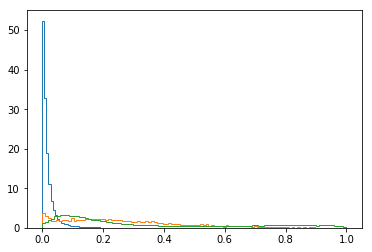

In [16]:
bins=100
feat='firstHcal_5'
plt.hist(df_cut[feat][df_cut['sample']=='elec'], bins=bins, label='elec', density=True, histtype='step')
plt.hist(df_cut[feat][df_cut['sample']=='pion'],bins=bins, label='pions', density=True, histtype='step')
plt.hist(df_cut[feat][df_cut['sample']=='PU'],bins=bins, label='PU', density=True, histtype='step')

In [17]:
#plot features distrib
plot= False
if plot:
    var_list= ['cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer',
           'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_spptot',
           'cl3d_szz', 'cl3d_srrtot',
           'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
           'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 
           'abseta', 'varee', 'varpp', 'varzz', 'varrr', 'EoT', 'first_1', 'first_2',
            'first_3', 'first_4', 'first_5', 'last_1', 'last_2', 'last_3', 'last_4',
            'last_5', 'last_6', 'last_7', 'last_8', 'last_9', 'firstHcal_1', 'firstHcal_2',
            'firstHcal_3', 'firstHcal_4', 'firstHcal_5', 'Emax_1', 'Emax_2G', 'Emax_2R', 'Emax_3',
            'Emax_4L', 'Emax_4R', 'Emax_5', 'ebm0', 'ebm1', 'hbm', 'reverse_ebm0', 'reverse_ebm1', 'reverse_hbm']

    nbins=100
    binmin=[1, 1, 1, 1, 0, 0, 0.0, 0.0, 0., -1.0, 328.15726, 0., 1.5, 4.004325, 0.67, 0.9, 1.6, 0, 0, 0.0, 0.0,
     0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0,0,0,0,0,0,0,0,0,0,0,0]
    binmax=[50.0, 36.0, 34.0, 50.0, 0.09, 0.075, 90, 0.01, 1, 5, 500, 36, 36, 36, 80, 200, 2.9, 0.007,
         0.005, 800, 0.0001, 1.0, 0.01, 0.03, 0.15, 0.5, 0.5,0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 
            0.3, 0.3,0.4, 0.6, 0.6,0.25,0.62,0.9,18000,9000,65536,18000,9000,65536]
    
    os.makedirs(workdir + '/distrib', exist_ok=True)
    for i,feat in enumerate(var_list):
        if i in [0,1,2,3]:
            nbins=36
        else: nbins= 100
        #print(feat, binmin[i], binmax[i])
        bins=np.linspace(binmin[i],binmax[i],nbins)
        plt.figure(figsize=(12,7))
        plt.hist(df_cut[feat][df_cut['sample']=='elec'], bins=bins, label='elec', density=True, histtype='step')
        plt.hist(df_cut[feat][df_cut['sample']=='pion'],bins=bins, label='pions', density=True, histtype='step')
        plt.hist(df_cut[feat][df_cut['sample']=='PU'],bins=bins, label='PU', density=True, histtype='step')
        plt.title("{} distribution ".format(feat))
        #plt.yscale('log')
        #plt.xlim(0,36)
        plt.legend()

        plt.savefig(workdir+'/distrib/{}.png'.format(feat))

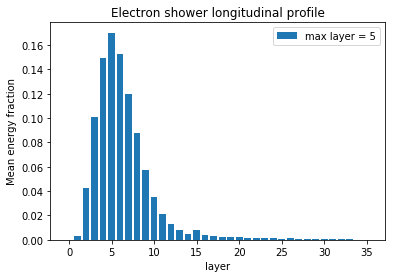

In [18]:
# plot longitudinal profile: mean fraction of elec pt / layer
frac={}
for n in range(n_layers):
    frac[n]=df_cut[df_cut['sample']=="elec"]['layer_{}'.format(n)]/df_cut[df_cut['sample']=="elec"]['cl3d_pt']
meanfrac=[frac[n].mean() for n in range(n_layers)]
plt.bar(range(n_layers),meanfrac, label= 'max layer = 5')
plt.xlabel('layer')
plt.ylabel('Mean energy fraction')
plt.title('Electron shower longitudinal profile')
plt.legend()

In [19]:
feature_set=6

In [20]:


if feature_set == 5:
    name = 'minimal w/ var & best pions '
    features = ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength','EoT',
                'Emax_3', 'ebm1', 'first_4', 'first_5', 'first_3', 'Emax_2']
    
        
if feature_set == 6:
    name = 'minimal w/ var & best PU '
    features = ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength', 'EoT',
                'ebm1', 'Emax_5', 'reverse_ebm1', 'first_4', 'Emax_1', 'Emax_4R', 'Emax_2R', 'Emax_4L', 'Emax_2L', 'first_2']

In [21]:
#chose signal and background
#weight calc

df_cut['signal']= 5
df_cut['weight']=0
df_cut['signal'][df_cut['sample']=='elec']= 1
df_cut['signal'][df_cut['sample']!='elec'] = 0

if bkg == 'pions':
    print('pions')

    data=df_cut[df_cut['sample']!='PU']
    tot_event=len(data)
    sig_event=len(data[df['sample']=='elec'])
    bkg_event=len(data[df['sample']=='pion'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event
    #print(ws)
    data['weight'][data['signal']==0]=wb
    #print(np.unique(data['weight']))

    #print(wb)
    data['weight'][data['signal']==1]=ws
    #print(np.unique(data['weight']))

elif bkg == 'PU':
    print('PU')
    data=df_cut[df_cut['sample']!='pion']
    tot_event=len(data)
    sig_event=len(data[df['sample']=='elec'])
    bkg_event=len(data[df['sample']=='PU'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event

    data['weight'][data['signal']==0]=wb
    data['weight'][data['signal']==1]=ws
print('signal weight = {}, bkg weight ={}'.format(ws, wb))

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


pions


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/pandas/core/generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be s

signal weight = 1.0321688105114484, bkg weight =32.08601108033241


In [22]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

#blancing illustration: hoe vs meanz
test= X_train_untouched[['cl3d_hoe', 'cl3d_meanz']]
plt.figure()
plt.scatter(X_train_untouched['cl3d_hoe'][y_train_untouched['signal']==0],X_train_untouched['cl3d_meanz'][y_train_untouched['signal']==0], label='pions', s=2 )
plt.scatter(X_train_untouched['cl3d_hoe'][y_train_untouched['signal']==1],X_train_untouched['cl3d_meanz'][y_train_untouched['signal']==1], label='elec', s=2 )
plt.ylabel('meanz')
plt.xlabel('hoe')
plt.xlim(0,5)
plt.legend()

oversample=imblearn.over_sampling.ADASYN()
X_smote2d, y_smote2d=oversample.fit_resample(X=X_train_untouched , y=y_train_untouched['signal'])

plt.figure()
plt.scatter(X_smote2d['cl3d_hoe'][y_smote2d==0],X_smote2d['cl3d_meanz'][y_smote2d==0], label='pions', s=2 )
plt.scatter(X_smote2d['cl3d_hoe'][y_smote2d==1],X_smote2d['cl3d_meanz'][y_smote2d==1], label='elec', s=2 )
plt.ylabel('meanz')
plt.xlabel('hoe')
plt.xlim(0,5)
plt.legend()

#blancing illustration: hoe vs meanz
test= X_train_untouched[['cl3d_hoe', 'cl3d_meanz']]
plt.figure()
plt.scatter(X_train_untouched['cl3d_hoe'][y_train_untouched['signal']==0],X_train_untouched['cl3d_meanz'][y_train_untouched['signal']==0], label='pions', s=2 )
plt.scatter(X_train_untouched['cl3d_hoe'][y_train_untouched['signal']==1],X_train_untouched['cl3d_meanz'][y_train_untouched['signal']==1], label='elec', s=2 )
plt.ylabel('meanz')
plt.xlabel('hoe')
plt.xlim(0,5)
plt.legend()

oversample=imblearn.over_sampling.SMOTE()
X_smote2d, y_smote2d=oversample.fit_resample(X=X_train_untouched , y=y_train_untouched['signal'])

plt.figure()
plt.scatter(X_smote2d['cl3d_hoe'][y_smote2d==0],X_smote2d['cl3d_meanz'][y_smote2d==0], label='pions', s=2 )
plt.scatter(X_smote2d['cl3d_hoe'][y_smote2d==1],X_smote2d['cl3d_meanz'][y_smote2d==1], label='elec', s=2 )
plt.ylabel('meanz')
plt.xlabel('hoe')
plt.xlim(0,5)
plt.legend()

In [23]:
balancing='comb' #'SMOTE', 'weights', 'ada', 'under', 'comb'

In [24]:
Counter= collections.Counter

In [25]:
print(data.columns.to_list())

['genpart_exeta', 'genpart_pt', 'cl3d_pt', 'cl3d_eta', 'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'matches', 'sample', 'abseta', 'layer_pt', 'layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12', 'layer_13', 'layer_14', 'layer_15', 'layer_16', 'layer_17', 'layer_18', 'layer_19', 'layer_20', 'layer_21', 'layer_22', 'layer_23', 'layer_24', 'layer_25', 'layer_26', 'layer_27', 'layer_28', 'layer_29', 'layer_30', 'layer_31', 'layer_32', 'layer_33', 'layer_34', 'layer_35', 'varee', 'varpp', 'varzz', 'varrr', 'EoT', 'first_1', 'first_2', 'first_3', 'first_4', 'first_5', 'last_1', 'last_2', 'last_3', 'last_4', 'last_5', 'last_6', 'last_

In [26]:
#normalize features
from sklearn import preprocessing
import pickle
scaler = preprocessing.StandardScaler()
x=data[features]

gridsearch_params = [
    (nbits, method)
    for nbits in [4,6,8,10,12]
    for method in ['uniform', 'percentile'] 
]
gs_len=len(gridsearch_params)
Results=pd.DataFrame(columns=['pred_test', 'true_test'])
for i,(nbits, method) in enumerate(gridsearch_params):
    print('iter {}/{}'.format(i+1, gs_len),nbits, method)
    X=data[features]
    for col in data[features].columns:
        X[col]=quantize(data[col], nbits, method)
    
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        data[['signal','weight','cl3d_eta','cl3d_pt', 'genpart_pt', 'genpart_exeta']],
                                                        test_size=0.2,random_state=42)

    ####balancing
    train_untouched=xgb.DMatrix(data=X_train,label=y_train['signal'],feature_names=features)
    y_train_untouched=y_train
    X_train_untouched=X_train
    if balancing == 'SMOTE':
        oversample=imblearn.over_sampling.SMOTE()
        X_train, y_train=oversample.fit_resample(X=X_train , y=y_train['signal'])
        y_train=pd.DataFrame(y_train)
        y_train['weight']=1
    elif balancing == 'ada':
        oversample=imblearn.over_sampling.ADASYN()
        X_train, y_train=oversample.fit_resample(X=X_train , y=y_train['signal'])
        y_train=pd.DataFrame(y_train)
        y_train['weight']=1
    elif balancing == 'under':
        undersample= imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5)
        X_train, y_train=oversample.fit_resample(X=X_train , y=y_train['signal'])
        y_train=pd.DataFrame(y_train)
        y_train['weight']=1
    elif balancing == 'comb':
        over=imblearn.over_sampling.SMOTE(sampling_strategy=0.2)
        under= imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5)
        X_train, y_train=over.fit_resample(X_train,y_train['signal'])
        X_train, y_train=under.fit_resample(X_train, y_train)
        y_train=pd.DataFrame(y_train)
        y_train['weight']=1

    res_dir=workdir+'/res/res_pt{}_vs{}_featset{}/quantized{}_{}_{}'.format(genptcut, bkg, feature_set,nbits, method, balancing)
    os.makedirs(res_dir, exist_ok=True)
    train= xgb.DMatrix(data=X_train,label=y_train['signal'], feature_names=features, weight=y_train['weight'])
    test= xgb.DMatrix(data=X_test,label=y_test['signal'],feature_names=features)

        
    ####DNN training
    #CV



    param = {
        'nthread' : 8,
        # Parameters that we are going to tune.
        'max_depth':2,
        'eta':0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        # Other parameters
        'objective':'binary:logistic',
        'eval_metric': 'auc', 
        'alpha':0.01,
        'lambda':10,
    }

    #use gpu if available
    gpu=tf.test.is_gpu_available(
        cuda_only=False, min_cuda_compute_capability=None
    )
    if gpu==True:
        param['tree_method']='gpu_hist'

    num_boost_round=200
    es_rounds=3

    metrics={'logloss','auc'} #last one used for es
    # set up cross validation:
    print('beginning cv')
    cv_results = xgb.cv(
        param,
        train,
        num_boost_round=num_boost_round,
        seed=40,
        nfold=5,
        metrics=metrics,
        #feval=SoverB,
        early_stopping_rounds=es_rounds,
        shuffle=True,
        verbose_eval=None
    )

    ## we define best score as the best test_auc penalized by the gap between train and test auc
    alpha=1 #(penalization)

    best_score=(cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).max()
    boost_rounds = (cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).argmax()
    #print('best score:{} reached in {} rounds'.format(best_score, boost_rounds))
    #Now train and fit best parameters BDT



    #print('Training on {} events, signal : {}, bkg: {}'.format(len(y_train),len(y_train[y_train['signal']==1]),len(y_train[y_train['signal']==0])))
    #print('Testing on {} events, signal : {}, bkg: {}'.format(len(y_test),len(y_test[y_test['signal']==1]),len(y_test[y_test['signal']==0])))
    eval_result = {}
    BDT = xgb.train(
        param,
        train,
        num_boost_round=int(boost_rounds/2),
        #feval = SoverB,
        evals=[(train, 'Train'),(test, "Test")],
        evals_result = eval_result,
        verbose_eval=None,
    )
    BDT.save_model(res_dir+'/model.model')
    print('model saved to {}'.format(res_dir+'/model.model'))
    #predictions_BDT_train=BDT.predict(train)
    #predictions_BDT_train_untouched=BDT.predict(train_untouched)
    Results.loc[i]=[BDT.predict(test), y_test['signal'].astype('int32')] 
    print('iteration over')
   
        

iter 1/10 4 uniform


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
W0720 15:48:04.006472 140272537384768 deprecation.py:323] From <ipython-input-26-58bee5114b38>:78: is_gpu_available (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:106: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


model saved to /grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset6/quantized4_uniform_comb/model.model
iteration over
iter 2/10 4 percentile


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:106: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


model saved to /grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset6/quantized4_percentile_comb/model.model
iteration over
iter 3/10 6 uniform


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:106: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


model saved to /grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset6/quantized6_uniform_comb/model.model
iteration over
iter 4/10 6 percentile


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:106: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


model saved to /grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset6/quantized6_percentile_comb/model.model
iteration over
iter 5/10 8 uniform


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:106: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


model saved to /grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset6/quantized8_uniform_comb/model.model
iteration over
iter 6/10 8 percentile


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:106: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


model saved to /grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset6/quantized8_percentile_comb/model.model
iteration over
iter 7/10 10 uniform


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:106: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


model saved to /grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset6/quantized10_uniform_comb/model.model
iteration over
iter 8/10 10 percentile


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:106: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


model saved to /grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset6/quantized10_percentile_comb/model.model
iteration over
iter 9/10 12 uniform


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:106: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


model saved to /grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset6/quantized12_uniform_comb/model.model
iteration over
iter 10/10 12 percentile


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:106: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


model saved to /grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset6/quantized12_percentile_comb/model.model
iteration over


In [27]:
#train without quantization

X=data[features]


X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    data[['signal','weight','cl3d_eta','cl3d_pt', 'genpart_pt', 'genpart_exeta']],
                                                    test_size=0.2,random_state=42)

####balancing
train_untouched=xgb.DMatrix(data=X_train,label=y_train['signal'],feature_names=features)
y_train_untouched=y_train
X_train_untouched=X_train
if balancing == 'SMOTE':
    oversample=imblearn.over_sampling.SMOTE()
    X_train, y_train=oversample.fit_resample(X=X_train , y=y_train['signal'])
    y_train=pd.DataFrame(y_train)
    y_train['weight']=1
elif balancing == 'ada':
    oversample=imblearn.over_sampling.ADASYN()
    X_train, y_train=oversample.fit_resample(X=X_train , y=y_train['signal'])
    y_train=pd.DataFrame(y_train)
    y_train['weight']=1
elif balancing == 'under':
    undersample= imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5)
    X_train, y_train=oversample.fit_resample(X=X_train , y=y_train['signal'])
    y_train=pd.DataFrame(y_train)
    y_train['weight']=1
elif balancing == 'comb':
    over=imblearn.over_sampling.SMOTE(sampling_strategy=0.2)
    under= imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5)
    X_train, y_train=over.fit_resample(X_train,y_train['signal'])
    X_train, y_train=under.fit_resample(X_train, y_train)
    y_train=pd.DataFrame(y_train)
    y_train['weight']=1

res_dir=workdir+'/res/res_pt{}_vs{}_featset{}/quantized{}_{}_{}'.format(genptcut, bkg, feature_set,nbits, method, balancing)
os.makedirs(res_dir, exist_ok=True)
train= xgb.DMatrix(data=X_train,label=y_train['signal'], feature_names=features, weight=y_train['weight'])
test= xgb.DMatrix(data=X_test,label=y_test['signal'],feature_names=features)


####DNN training
#CV



param = {
    'nthread' : 8,
    # Parameters that we are going to tune.
    'max_depth':2,
    'eta':0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    # Other parameters
    'objective':'binary:logistic',
    'eval_metric': 'auc', 
    'alpha':0.01,
    'lambda':10,
}

#use gpu if available
gpu=tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)
if gpu==True:
    param['tree_method']='gpu_hist'

num_boost_round=200
es_rounds=3

metrics={'logloss','auc'} #last one used for es
# set up cross validation:
print('beginning cv')
cv_results = xgb.cv(
    param,
    train,
    num_boost_round=num_boost_round,
    seed=40,
    nfold=5,
    metrics=metrics,
    #feval=SoverB,
    early_stopping_rounds=es_rounds,
    shuffle=True,
    verbose_eval=None
)

## we define best score as the best test_auc penalized by the gap between train and test auc
alpha=1 #(penalization)

best_score=(cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).max()
boost_rounds = (cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).argmax()
#print('best score:{} reached in {} rounds'.format(best_score, boost_rounds))
#Now train and fit best parameters BDT



#print('Training on {} events, signal : {}, bkg: {}'.format(len(y_train),len(y_train[y_train['signal']==1]),len(y_train[y_train['signal']==0])))
#print('Testing on {} events, signal : {}, bkg: {}'.format(len(y_test),len(y_test[y_test['signal']==1]),len(y_test[y_test['signal']==0])))
eval_result = {}
BDT = xgb.train(
    param,
    train,
    num_boost_round=int(boost_rounds/2),
    #feval = SoverB,
    evals=[(train, 'Train'),(test, "Test")],
    evals_result = eval_result,
    verbose_eval=None,
)
res=BDT.predict(test)

beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:92: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


AUC Score (Test): 99.747298%
AUC Score (Test): 99.722914%
AUC Score (Test): 99.704042%
AUC Score (Test): 99.731058%
AUC Score (Test): 99.753702%
AUC Score (Test): 99.751632%
AUC Score (Test): 99.747298%
AUC Score (Test): 99.615041%
AUC Score (Test): 99.715233%
AUC Score (Test): 99.771504%
AUC Score (Test): 99.762530%
AUC Score (Test): 99.763008%


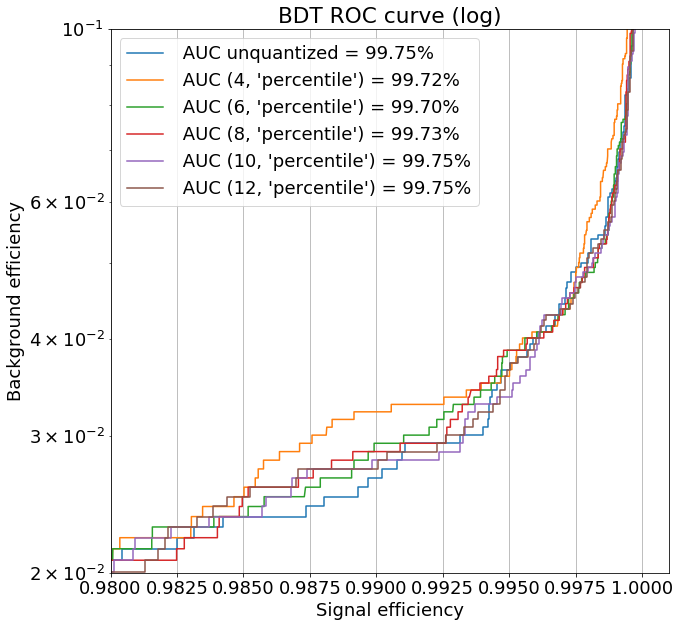

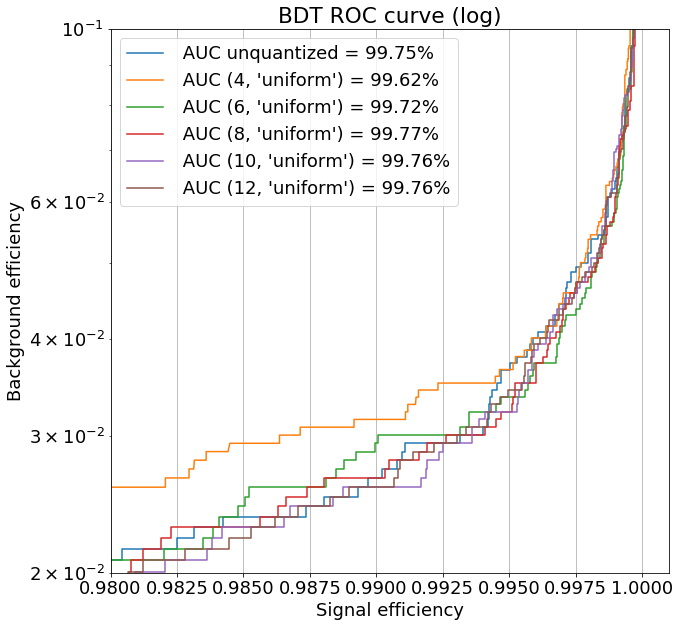

In [33]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
fpr, tpr, threshold = roc_curve(y_test['signal'],res, pos_label=1)
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
print ("AUC Score (Test): {:4%}".format(roc_auc_test))
plt.plot(tpr,fpr, label =' AUC unquantized = {:2.2%}' .format(roc_auc_test))
for i in range(len(Results)):
    if 'uniform' not in gridsearch_params[i]:
        fpr, tpr, threshold = roc_curve(Results['true_test'].iloc[i],Results['pred_test'].iloc[i], pos_label=1)
        fpr.sort()
        tpr.sort()
        roc_auc_test = auc(fpr, tpr)
        print ("AUC Score (Test): {:4%}".format(roc_auc_test))
        plt.plot(tpr,fpr, label =' AUC {} = {:2.2%}' .format(gridsearch_params[i],roc_auc_test))
plt.yscale('log')
plt.xlim(0.98,1.001)
plt.ylim(2e-2,1e-1)
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.title('BDT ROC curve (log)')
plt.grid()
plt.legend(loc='upper left')

plt.figure(figsize=(10,10))
fpr, tpr, threshold = roc_curve(y_test['signal'],res, pos_label=1)
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
print ("AUC Score (Test): {:4%}".format(roc_auc_test))
plt.plot(tpr,fpr, label =' AUC unquantized = {:2.2%}' .format(roc_auc_test))
plt.savefig('/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vsPU_featset6/quantile_comparison.png')
for i in range(len(Results)):
    if 'percentile' not in gridsearch_params[i]:
        fpr, tpr, threshold = roc_curve(Results['true_test'].iloc[i],Results['pred_test'].iloc[i], pos_label=1)
        fpr.sort()
        tpr.sort()
        roc_auc_test = auc(fpr, tpr)
        print ("AUC Score (Test): {:4%}".format(roc_auc_test))
        plt.plot(tpr,fpr, label =' AUC {} = {:2.2%}' .format(gridsearch_params[i],roc_auc_test))
plt.yscale('log')
plt.xlim(0.98,1.001)
plt.ylim(2e-2,1e-1)
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.title('BDT ROC curve (log)')
plt.grid()
plt.legend(loc='upper left')
plt.savefig('/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vsPU_featset6/uniform_comparison.png')

In [29]:
res_dir

'/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset6/quantized12_percentile_comb'

In [30]:
    train= xgb.DMatrix(data=X_train,label=y_train['signal'], feature_names=features, weight=y_train['weight'])
    test= xgb.DMatrix(data=X_test,label=y_test['signal'],feature_names=features)

minimal best : (2,0.1,0.01,10,3)
full best (2,0.01,10,10,5)

In [31]:
len(predictions_BDT_train)

NameError: name 'predictions_BDT_train' is not defined

In [ ]:
len(y_train)

In [ ]:
len(data[data['signal']==0])

In [ ]:
# shap values
import shap
# select a set of background examples to take an expectation over
#background = X_train.to_numpy()[np.random.choice(X_train.shape[0], 1000, replace=False)]

# explain predictions of the model on four images
explainer = shap.Explainer(BDT)
a= data[features][(data['signal']==1).values].sample(2000)
b = data[features][(data['signal']==0).values].sample(2000)
shap_df= pd.concat([a,b])

#shap_values = explainer.shap_values(X_test.to_numpy()[np.random.choice(X_test.shape[0], 1000, replace=False)])
shap_values = explainer.shap_values(shap_df.to_numpy())
col_names=[val for val in shap_df.columns if val != 'abseta']
col_names.append('abseta')

plt.figure(figsize=(10,5))
#shap.summary_plot(shap_values, X_test.to_numpy()[np.random.choice(X_test.shape[0], 1000, replace=False)], 
#                  features,max_display=99, show=False, alpha = 0.7 )

shap.summary_plot(shap_values, shap_df.to_numpy() ,shap_df.columns,max_display=99, show=False, alpha = 0.8 )
plt.xlabel('Shap value', fontsize=16)

plt.savefig(res_dir+'/importance_violin.png', bbox_inches='tight')


In [ ]:
bkg

In [ ]:
# plot the feature attributions
#shap.image_plot(shap_values, -x_test[1:5])
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], features)

In [ ]:
# shap values
import shap
# select a set of background examples to take an expectation over
#background = X_train.to_numpy()[np.random.choice(X_train.shape[0], 1000, replace=False)]

# explain predictions of the model on four images
explainer = shap.Explainer(BDT)
a= X_test[(y_test['signal']==1).values].sample(500)
b = X_test[(y_test['signal']==0).values].sample(500)
shap_df= pd.concat([a,b])

#shap_values = explainer.shap_values(X_test.to_numpy()[np.random.choice(X_test.shape[0], 1000, replace=False)])
shap_values = explainer.shap_values(shap_df.to_numpy())


In [ ]:
col_names=[val for val in shap_df.columns if val != 'abseta']
col_names.append('abseta')


In [ ]:
shap_df.columns

In [ ]:
col_names

In [ ]:
bkg

In [ ]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
shap=pd.DataFrame(shap_values, columns=col_names)
shap_mean=[]
for column in shap.columns:
    shap_mean.append(np.abs(shap[column]).mean())
abs(shap).mean().sort_values().plot(kind='barh', figsize=(16,10))
plt.savefig(res_dir+'/importance_shap.png')

In [ ]:
shap_values


plt.figure(figsize=(8,4))
#shap.summary_plot(shap_values, X_test.to_numpy()[np.random.choice(X_test.shape[0], 1000, replace=False)], 
#                  features,max_display=99, show=False, alpha = 0.7 )

shap.summary_plot(shap_values, shap_df.to_numpy() , col_names,max_display=99, show=False, alpha = 0.7 )
plt.xlabel('Shap value', fontsize=16)
plt.show()


In [ ]:
matplotlib.rcParams.update({'font.size': 18})
y_test['BDT']=predictions_BDT_test
#y_test['BDT_layer']=pred_PU_layer

plt.figure(figsize=(20,15))
score=[]
thr=0.95



#plot AUC
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),predictions_BDT_test, pos_label=1,  sample_weight=y_test['weight'])
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
roc_test=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
roc_cut_test=roc_test[roc_test['tpr']>thr];
print ("AUC Score (Test): {:4%}".format(roc_auc_test))
plt.plot(tpr,fpr, label =' AUC test = %0.4f' %(roc_auc_test))


fpr, tpr, threshold = roc_curve(y_train['signal'].astype('int32'),predictions_BDT_train, pos_label=1,sample_weight=y_train['weight'])
fpr.sort()
tpr.sort()
roc_auc_train = auc(fpr, tpr)
roc_auc_train = auc(fpr, tpr)
roc_train=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
roc_cut_train=roc_train[roc_train['tpr']>thr];
print ("AUC Score (Train): {:4%}".format(roc_auc_train))
plt.plot(tpr,fpr, label =' AUC train = %0.4f' %(roc_auc_train))
plt.xlim(0.9,1.001)
plt.yscale('log')
plt.ylim(1e-3,1.001)
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.title('BDT ROC curve')
plt.axvline(x=thr, label='WP', c='k')
plt.grid()
plt.legend()
print('score  = {}%'.format(np.min(roc_cut_test['fpr'])*100))

In [ ]:
# calc BDT cut
thr=0.99
BDT_cut=np.interp(thr,roc_test['tpr'], roc_test['threshold'])
with open(file_name, 'a') as f:
    f.write('BDT cut ={}  for tpr = {} and fpr {}\n'.format( np.interp(thr,roc_test['tpr'], roc_test['threshold']), np.interp(thr,roc_test['tpr'], roc_test['tpr']), np.interp(thr,roc_test['tpr'], roc_test['fpr'])))

print('BDT cut ={}  for tpr = {} and fpr {}'.format( np.interp(thr,roc_test['tpr'], roc_test['threshold']),
                                                    np.interp(thr,roc_test['tpr'], roc_test['tpr']),
                                                    np.interp(thr,roc_test['tpr'], roc_test['fpr'])))

In [ ]:
#binning y_test


def calctp(group):
    pos=len(group[(group['BDT']>BDT_cut) & (group['signal']==1)])
    truepos= len(group[group['signal']==1])
    
    if truepos !=0 :return pos/truepos
    else : return np.nan
def calcfp(group):
    fp = len(group[(group['BDT']>BDT_cut) & (group['signal']==0)])
    trueneg = len(group[group['signal']==0])
    if trueneg !=0: return fp/trueneg
    else: return np.nan

In [ ]:

#CALCULATE ERROR BARS
conf_level=0.99
from scipy import stats
#normal
#def error(total, score, conf_level):
#    alpha=(1-conf_level)/2
#    sigma=np.sqrt(score*(1-score)/total)
#    delta=np.abs(score-stats.norm.ppf(1-alpha,loc=score, scale=sigma))
#    return delta

#clopper pearson
def error(total, score, conf_level):
    alpha=(1-conf_level)
    n=total
    k=score*n
    lo = score-stats.beta.ppf(alpha/2, k, n-k+1)
    hi = stats.beta.ppf(1 - alpha/2, k+1, n-k)-score
    return lo, hi


In [ ]:
y_train=y_train_untouched

In [ ]:
pt_bins=[0,5,10,15,20,30,40,60,80,100,120,140,160,180,200,220]
eta_bins=[1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0]
pt_points=[2.5,7.5,12.5,17.5,25,35,50,70,90,110,130,150,170,190,210]
eta_points=[1.7,1.9,2.1,2.3,2.5,2.7,2.9]
y_test['BDT']=predictions_BDT_test
y_train['BDT']=predictions_BDT_train_untouched

from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
"""fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),predictions_BDT_test, pos_label=1,  sample_weight=y_test['weight'])
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
roc_test=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
roc_cut_test=roc_test[roc_test['tpr']>thr];
"""
conf_level=0.67


y_test['genpt_binned']=pd.cut(y_test['genpart_pt'], pt_bins)
group=y_test.groupby('genpt_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y_test.groupby('genpt_binned').size(), tpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(pt_points, tpr.values, yerr=[lo,hi], label ='signal efficiency test ({} conf level)'.format(conf_level))
y_train['genpt_binned']=pd.cut(y_train['genpart_pt'], pt_bins)
group=y_train.groupby('genpt_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y_train.groupby('genpt_binned').size(), tpr, conf_level)
plt.errorbar(pt_points, tpr.values, yerr=[lo,hi], label ='signal efficiency train({} conf level)'.format(conf_level))
plt.ylabel('signal efficiency')
plt.xlabel('gen pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvspt_WP{}.png'.format(thr))


y_test['cl3dpt_binned']=pd.cut(y_test['cl3d_pt'], pt_bins)
group=y_test.groupby('cl3dpt_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y_test.groupby('cl3dpt_binned').size(), fpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(pt_points, fpr.values, yerr=[lo,hi], label ='bkg efficiency test ({} conf level)'.format(conf_level))
y_train['cl3dpt_binned']=pd.cut(y_train['cl3d_pt'], pt_bins)
group=y_train.groupby('cl3dpt_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y_train.groupby('cl3dpt_binned').size(), fpr, conf_level)
plt.errorbar(pt_points, fpr.values, yerr=[lo,hi], label ='bkg efficiency train ({} conf level)'.format(conf_level))
plt.ylabel('bkg efficiency')
plt.xlabel('cluster pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvspt_WP{}.png'.format(thr))


y_test['geneta_binned']=pd.cut(np.abs(y_test['genpart_exeta']), eta_bins)
group=y_test.groupby('geneta_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y_test.groupby('geneta_binned').size(), fpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(eta_points, tpr.values, yerr=[lo,hi], label ='signal efficiency test ({} conf level)'.format(conf_level))
y_train['geneta_binned']=pd.cut(np.abs(y_train['genpart_exeta']), eta_bins)
group=y_train.groupby('geneta_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y_train.groupby('geneta_binned').size(), fpr, conf_level)
plt.errorbar(eta_points, tpr.values, yerr=[lo,hi], label ='signal efficiency train ({} conf level)'.format(conf_level))
plt.ylabel('signal efficiency')
plt.xlabel('gen eta ')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvseta_WP{}.png'.format(thr))


y_test['cl3deta_binned']=pd.cut(np.abs(y_test['cl3d_eta']), eta_bins)
group=y_test.groupby('cl3deta_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y_test.groupby('cl3deta_binned').size(), fpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(eta_points, fpr.values, yerr=[lo,hi], label ='bkg efficiency test ({} conf level)'.format(conf_level))

y_train['cl3deta_binned']=pd.cut(np.abs(y_train['cl3d_eta']), eta_bins)
group=y_train.groupby('cl3deta_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y_train.groupby('cl3deta_binned').size(), fpr, conf_level)
plt.errorbar(eta_points, fpr.values, yerr=[lo,hi], label ='bkg efficiency train ({} conf level)'.format(conf_level))

plt.ylabel('bkg efficiency')
plt.xlabel('cluster eta')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvseta_WP{}.png'.format(thr))


In [ ]:
pt_bins=[0,5,10,15,20,30,40,60,80,100,120,140,160,180,200,220]
eta_bins=[1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0]
pt_points=[2.5,7.5,12.5,17.5,25,35,50,70,90,110,130,150,170,190,210]
eta_points=[1.7,1.9,2.1,2.3,2.5,2.7,2.9]
y=data[['signal','weight','cl3d_eta','cl3d_pt', 'genpart_pt', 'genpart_exeta']]
sample = xgb.DMatrix(data=pd.DataFrame(X, columns=features),label=y['signal'],feature_names=features, weight=y['weight'])
y['BDT']=BDT.predict(sample)


from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
fpr, tpr, threshold = roc_curve(y['signal'].astype('int32'),y['BDT'], pos_label=1,  sample_weight=y['weight'])
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
roc_test=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
roc_cut_test=roc_test[roc_test['tpr']>thr];

conf_level=0.67


y['cl3dpt_binned']=pd.cut(y['cl3d_pt'], pt_bins)
group=y.groupby('cl3dpt_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y.groupby('cl3dpt_binned').size(), tpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(pt_points, tpr.values, yerr=[lo,hi], label ='signal efficiency ({} conf level)'.format(conf_level))
plt.ylabel('signal efficiency')
plt.xlabel('cl3d pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvspt_WP{}.png'.format(thr))


y['cl3dpt_binned']=pd.cut(y['cl3d_pt'], pt_bins)
group=y.groupby('cl3dpt_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y.groupby('cl3dpt_binned').size(), fpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(pt_points, fpr.values, yerr=[lo,hi], label ='bkg efficiency ({} conf level)'.format(conf_level))
plt.ylabel('bkg efficiency')
plt.xlabel('cluster pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvspt_WP{}.png'.format(thr))


y['cl3deta_binned']=pd.cut(np.abs(y['cl3d_eta']), eta_bins)
group=y.groupby('cl3deta_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y.groupby('cl3deta_binned').size(), fpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(eta_points, tpr.values, yerr=[lo,hi], label ='signal efficiency ({} conf level)'.format(conf_level))
plt.ylabel('signal efficiency')
plt.xlabel('cl3d eta ')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvseta_WP{}.png'.format(thr))


y['cl3deta_binned']=pd.cut(np.abs(y['cl3d_eta']), eta_bins)
group=y.groupby('cl3deta_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y.groupby('cl3deta_binned').size(), fpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(eta_points, fpr.values, yerr=[lo,hi], label ='bkg efficiency ({} conf level)'.format(conf_level))
plt.ylabel('bkg efficiency')
plt.xlabel('cluster eta')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvseta_WP{}.png'.format(thr))


In [ ]:
if bkg =='pions':
    
    y['geneta_binned']=pd.cut(np.abs(y['genpart_exeta']), eta_bins)
    group=y.groupby('geneta_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=error(y.groupby('geneta_binned').size(), fpr, conf_level)
    plt.figure(figsize=(10,6))
    plt.errorbar(eta_points, fpr.values, yerr=[lo,hi], label ='bkg efficiency ({} conf level)'.format(conf_level))
    plt.ylabel('bkg efficiency')
    plt.xlabel('gen eta')
    plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
    plt.legend(loc='best')
    plt.savefig(res_dir+'/bkgeffvseta_WP{}.png'.format(thr))

    y['genpt_binned']=pd.cut(y['genpart_pt'], pt_bins)
    group=y.groupby('genpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=error(y.groupby('genpt_binned').size(), fpr, conf_level)
    plt.figure(figsize=(10,6))
    plt.errorbar(pt_points, fpr.values, yerr=[lo,hi], label ='bkg efficiency ({} conf level)'.format(conf_level))
    plt.ylabel('bkg efficiency')
    plt.xlabel('gen pt (GeV)')
    plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
    plt.legend(loc='best')
    plt.savefig(res_dir+'/bkgeffvspt_WP{}.png'.format(thr))
    
    y['geneta_binned']=pd.cut(np.abs(y['genpart_exeta']), eta_bins)
    group=y.groupby('geneta_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=error(y.groupby('geneta_binned').size(), fpr, conf_level)
    plt.figure(figsize=(10,6))
    plt.errorbar(eta_points, tpr.values, yerr=[lo,hi], label ='signal efficiency ({} conf level)'.format(conf_level))
    plt.ylabel('signal efficiency')
    plt.xlabel('gen eta ')
    plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
    plt.legend(loc='best')
    plt.savefig(res_dir+'/sigeffvseta_WP{}.png'.format(thr))

    y['genpt_binned']=pd.cut(y['genpart_pt'], pt_bins)
    group=y.groupby('genpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=error(y.groupby('genpt_binned').size(), tpr, conf_level)
    plt.figure(figsize=(10,6))
    plt.errorbar(pt_points, tpr.values, yerr=[lo,hi], label ='signal efficiency ({} conf level)'.format(conf_level))
    plt.ylabel('signal efficiency')
    plt.xlabel('gen pt (GeV)')
    plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
    plt.legend(loc='best')
    plt.savefig(res_dir+'/sigeffvspt_WP{}.png'.format(thr))



In [ ]:
y['geneta_binned']=pd.cut(np.abs(y['genpart_exeta']), eta_bins)
group=y.groupby('geneta_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y.groupby('geneta_binned').size(), fpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(eta_points, tpr.values, yerr=[lo,hi], label ='signal efficiency ({} conf level)'.format(conf_level))
plt.ylabel('signal efficiency')
plt.xlabel('gen eta ')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvseta_WP{}.png'.format(thr))

y['genpt_binned']=pd.cut(y['genpart_pt'], pt_bins)
group=y.groupby('genpt_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y.groupby('genpt_binned').size(), tpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(pt_points, tpr.values, yerr=[lo,hi], label ='signal efficiency ({} conf level)'.format(conf_level))
plt.ylabel('signal efficiency')
plt.xlabel('gen pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvspt_WP{}.png'.format(thr))

#res pion BDT
AUC Score (Test): 99.770155%
AUC Score (Train): 99.903230%
background rejection test = 0.9882920110192837, train = 0.994824909435915
#res PU BDT
AUC Score (Test): 99.901765%
AUC Score (Train): 99.914897%
background rejection test = 0.9994748699879739, train = 0.9995563555778215

In [ ]:
data_dir

In [ ]:
file= '/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/preprocessing/200PU/PU.h5'

In [34]:
df

,genpart_exeta,genpart_pt,cl3d_pt,cl3d_eta,cl3d_showerlength,cl3d_coreshowerlength,cl3d_firstlayer,cl3d_maxlayer,cl3d_seetot,cl3d_seemax,...,cl3d_hoe,cl3d_meanz,cl3d_layer10,cl3d_layer50,cl3d_layer90,cl3d_ntc67,cl3d_ntc90,layer,matches,sample
0,-3.058827,127.395210,143.920640,-3.051442,38.0,17.0,1.0,11.0,0.041038,0.067128,...,0.024321,340.96198,3.086457,6.334400,11.230371,15.309133,80.425820,"[0.0, 0.53237414, 4.0429306, 8.128277, 13.3131...",True,elec
1,3.069293,127.395210,137.564580,3.058379,36.0,14.0,1.0,11.0,0.042772,0.093859,...,0.005058,338.35217,3.141483,5.657351,9.109265,11.527929,65.916080,"[0.0, 0.3103639, 2.8518376, 7.9431815, 15.8064...",True,elec
2,1.549613,148.584270,142.986200,1.550624,23.0,12.0,1.0,7.0,0.007129,0.020342,...,0.009144,334.66962,2.641895,4.511642,7.109204,9.232396,38.569500,"[0.0, 0.22814505, 3.4763198, 15.744082, 32.815...",True,elec
3,-1.512490,148.584270,122.889640,-1.515032,39.0,10.0,1.0,7.0,0.006228,0.014429,...,0.005977,332.04315,1.714867,3.642661,5.913682,9.600592,25.926369,"[0.0, 1.1702224, 15.306884, 26.044731, 27.9676...",True,elec
4,-2.083180,154.033370,149.098430,-2.083827,31.0,15.0,1.0,9.0,0.012683,0.025464,...,0.003179,335.98438,2.761477,4.907373,7.849155,9.621163,37.922260,"[0.0, 0.17111729, 3.4286888, 14.427039, 26.879...",True,elec
5,2.042377,154.033370,151.865260,2.043225,27.0,14.0,1.0,9.0,0.013754,0.036191,...,0.008068,335.43707,2.472487,4.710957,7.846570,10.780541,47.386660,"[0.0, 0.41372758, 5.5145664, 18.49278, 27.0861...",True,elec
6,-1.922227,42.293007,45.829544,-1.920958,23.0,12.0,1.0,9.0,0.010576,0.049145,...,0.002965,335.19380,2.501238,4.696042,7.570047,10.189551,31.942852,"[0.0, 0.038867574, 1.5339532, 5.186448, 7.7068...",True,elec
7,1.919625,42.293007,53.038410,1.924154,32.0,11.0,1.0,9.0,0.013068,0.060379,...,0.208449,335.92917,2.359467,4.581114,7.651367,14.817432,49.302350,"[0.0, 0.08360979, 2.1163998, 5.6369247, 7.7133...",True,elec
8,-1.599848,127.057950,121.928250,-1.601202,27.0,14.0,1.0,7.0,0.007926,0.027144,...,0.000000,334.17654,2.217982,4.349603,7.197191,11.896424,42.801136,"[0.0, 0.9393397, 7.1273284, 17.707031, 25.4874...",True,elec
9,1.595385,127.057950,128.978790,1.596474,27.0,12.0,1.0,7.0,0.008261,0.035981,...,0.001321,333.75020,2.151341,4.197350,6.980294,11.633962,39.080513,"[0.0, 0.6775173, 8.8257065, 20.6163, 27.7429, ...",True,elec


In [36]:
%%time
columns=['genpart_exeta',
         'genpart_pt',
 'cl3d_pt',
 'cl3d_eta',
 'cl3d_showerlength',
 'cl3d_coreshowerlength',
 'cl3d_firstlayer',
 'cl3d_maxlayer',
 'cl3d_seetot',
 'cl3d_seemax',
 'cl3d_spptot',
 'cl3d_sppmax',
 'cl3d_szz',
 'cl3d_srrtot',
 'cl3d_srrmax',
 'cl3d_srrmean',
 'cl3d_emaxe',
 'cl3d_hoe',
 'cl3d_meanz',
 'cl3d_layer10',
 'cl3d_layer50',
 'cl3d_layer90',
 'cl3d_ntc67',
 'cl3d_ntc90',
 'layer',
 'sample',
  'matches',
         
        ]
bkg='QCD'
col_QCD = ['event', 'genjet_n', 'genjet_energy', 'genjet_pt', 'genjet_eta',
       'genjet_phi', 'cl3d_pt', 'cl3d_energy', 'cl3d_eta',
       'cl3d_phi', 
       'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer',
       'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot',
       'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean',
       'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
       'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'layer', 'deta', 'dphi',
       'deltar', 'matches',]
#df_sig= pd.read_csv(data_dir+'/{}.csv'.format(signal), usecols=columns, low_memory=True)
df_bkg= pd.read_csv(data_dir+'/{}.csv'.format(bkg), usecols=col_QCD, low_memory=True)
df_bkg['sample']=bkg

print('done')

done
CPU times: user 14.3 s, sys: 2.55 s, total: 16.8 s
Wall time: 17 s


In [39]:
if bkg == 'QCD':
    sel = ((np.abs(df_bkg['cl3d_eta'])>etamin) & (np.abs(df_bkg['cl3d_eta'])<etamax )&(df_bkg['cl3d_pt']>cl3dptcut))
df_bkg_cut=df_bkg[sel]
df_bkg_cut.dropna(inplace=True)



/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [41]:
df_cut=df.append(df_bkg)

In [44]:
%%time
#cut
algo_cut={}

def tolist(x):
    x.test=x.layer[1:-1].split(',')
    return x.test



#cut on cl3deta
df_cut['abseta']=np.abs(df_cut['cl3d_eta'])
sel=(df_cut['abseta']>etamin) & (df_cut['abseta']<etamax)
df_cut=df_cut[sel]
print('cl3d eta cut:', len(df_cut), len(df_cut[df_cut['sample']=='elec']))
#print('PU: ', len(df_cut[df_cut['sample']=='PU']))
#layer_pt preproc
df_cut['layer_pt']=df_cut.apply(tolist, axis=1)
df_cut.drop('layer', axis=1, inplace=True)
print("done")
def layering (x):
    return float(x.layer_pt[n])

##besoin de créer une variable par layer?
algo_layer={}
n_layers=len(df_cut['layer_pt'].iloc[0])
#print(n_layers)
layer_columns=[]

for n in range(n_layers):
    print('layering: {}/{}\r'.format(n+1,n_layers),end='', flush=True)
    df_cut['layer_{}'.format(n)]=df_cut.apply(layering, axis=1)
    layer_columns.append('layer_{}'.format(n))
print("done layering")

cl3d eta cut: 398124 225493
done
done layering36
CPU times: user 5min 15s, sys: 30.8 s, total: 5min 46s
Wall time: 5min 47s


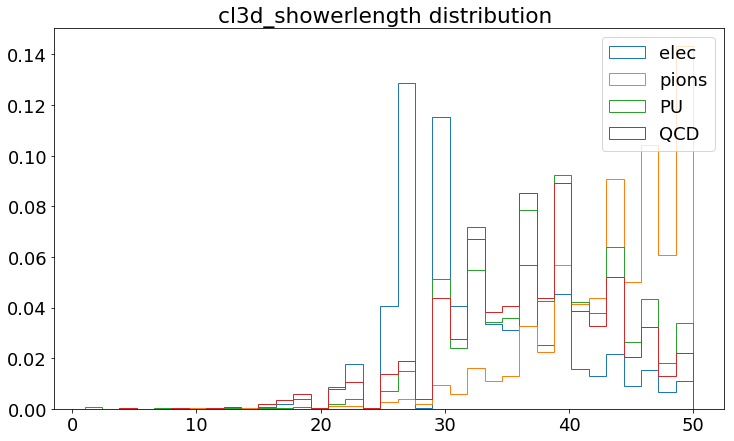

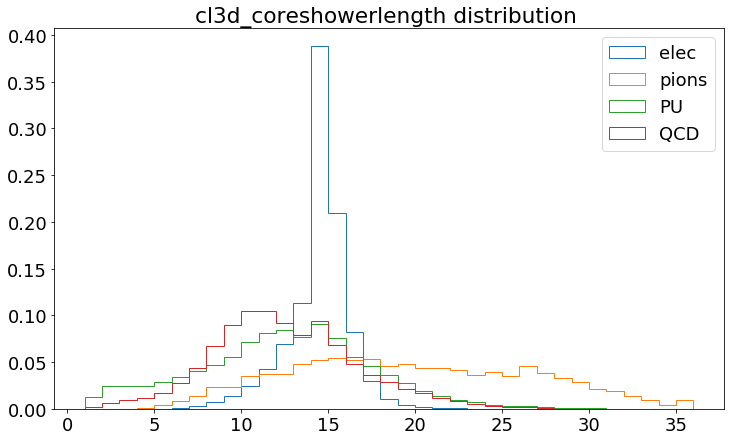

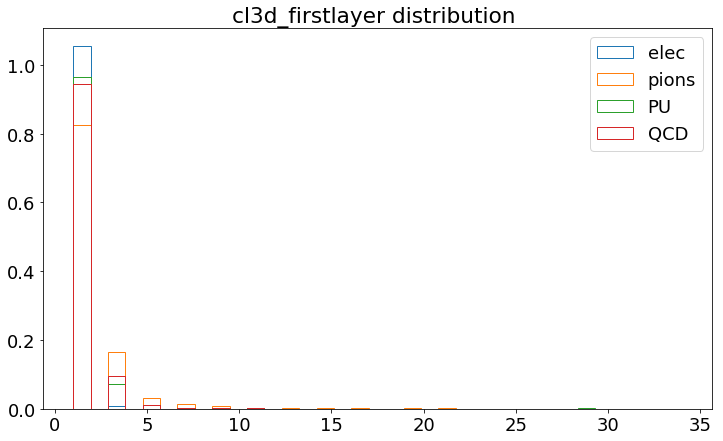

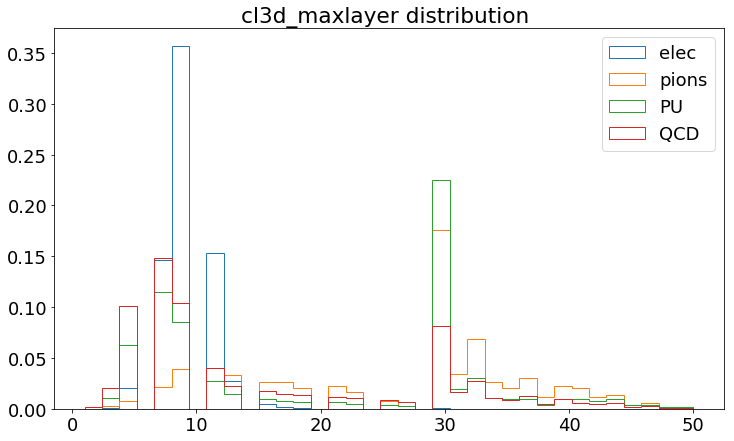

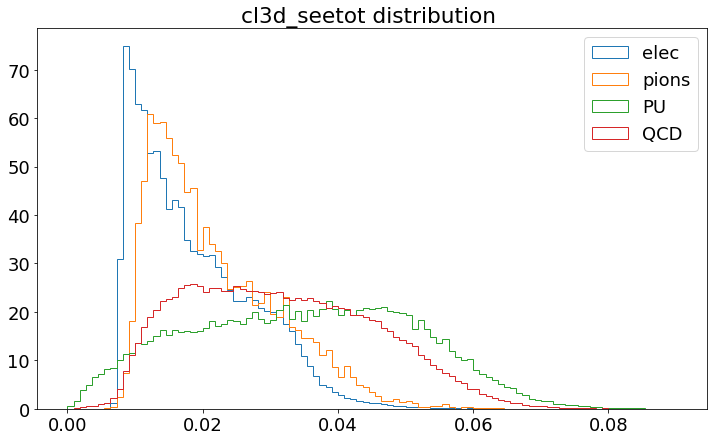

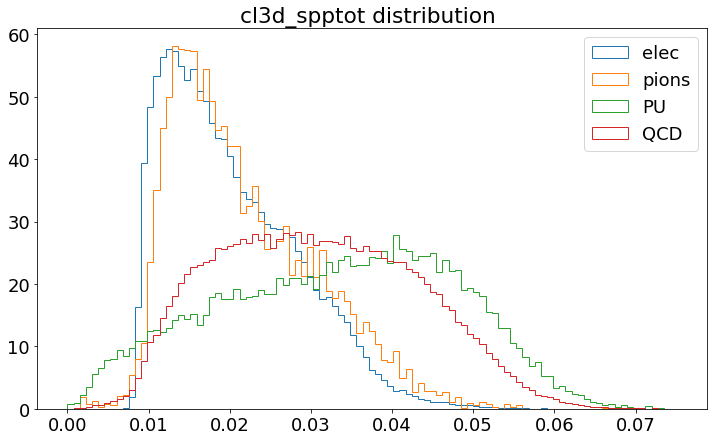

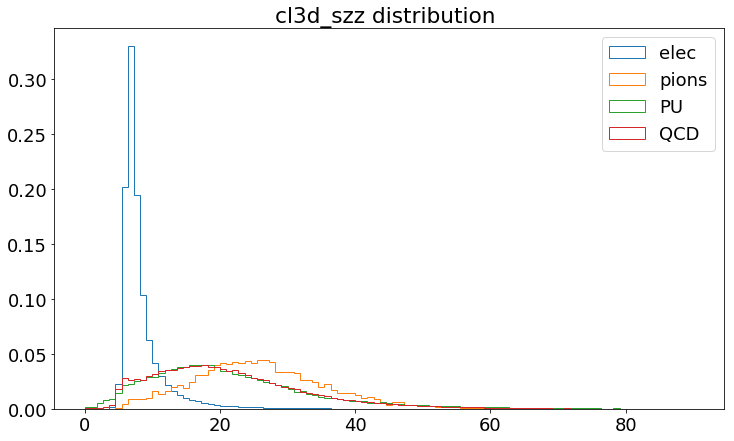

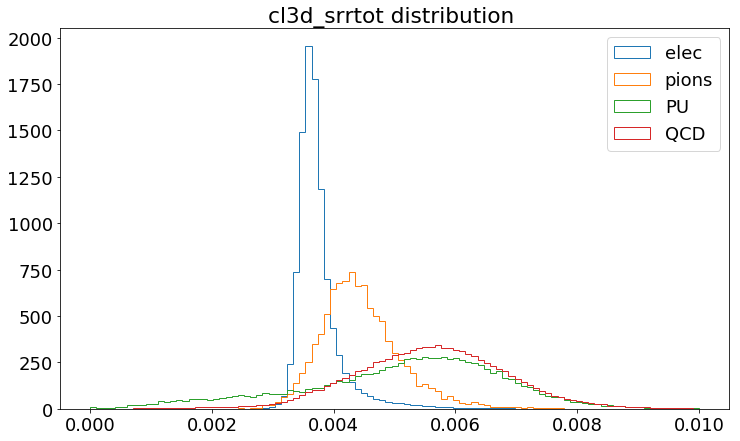

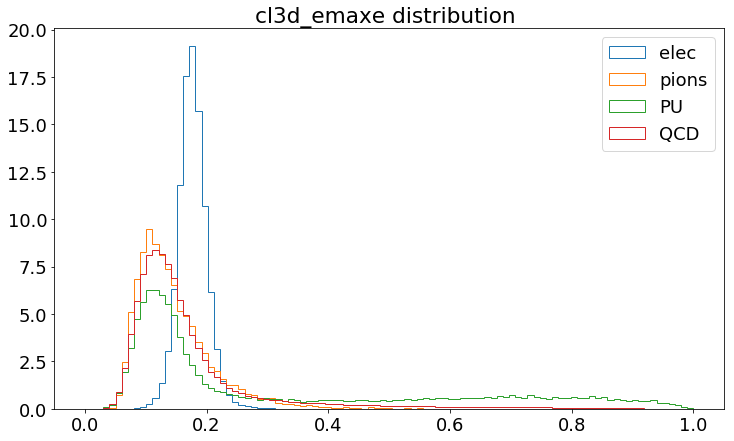

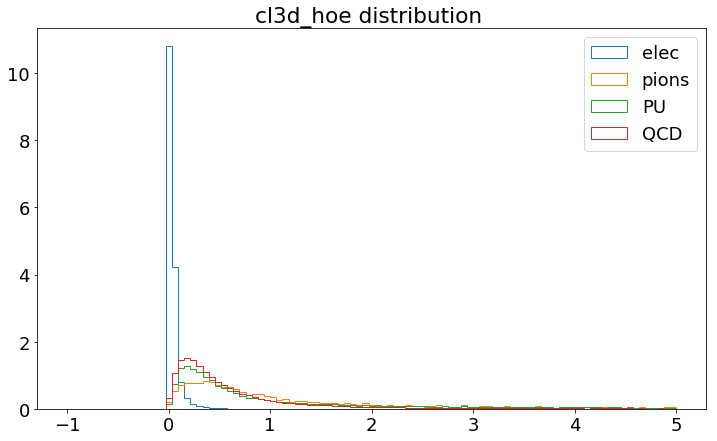

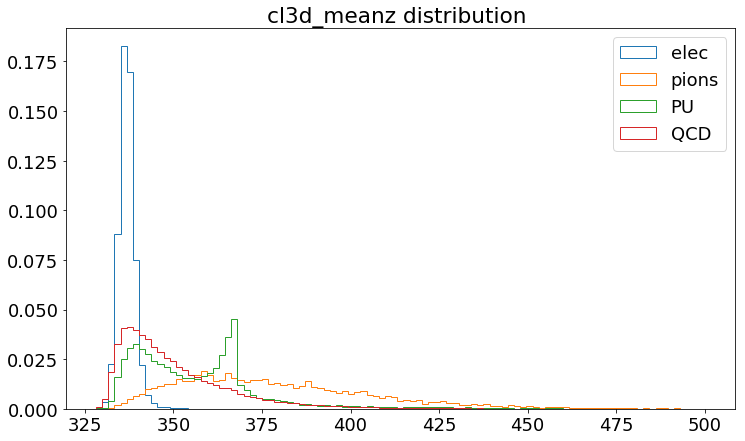

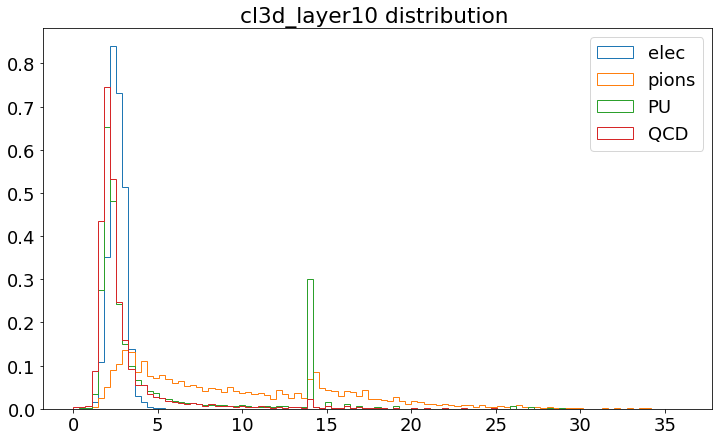

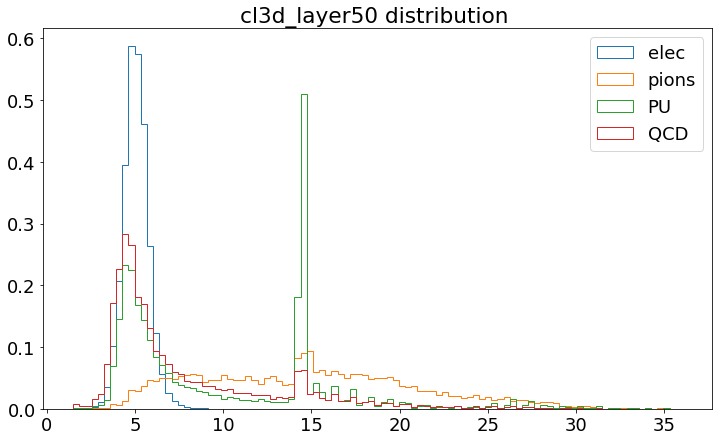

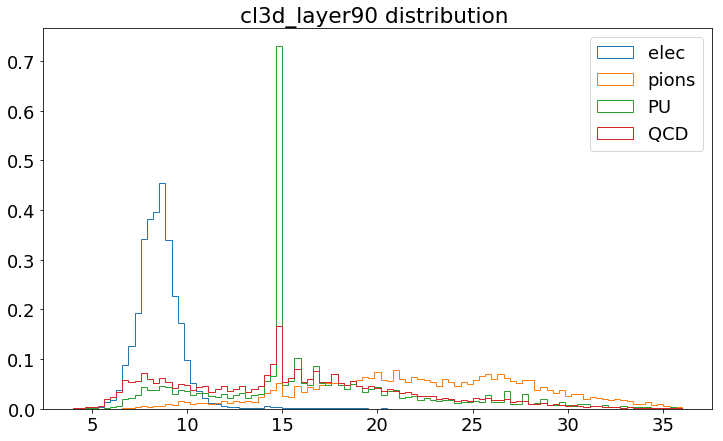

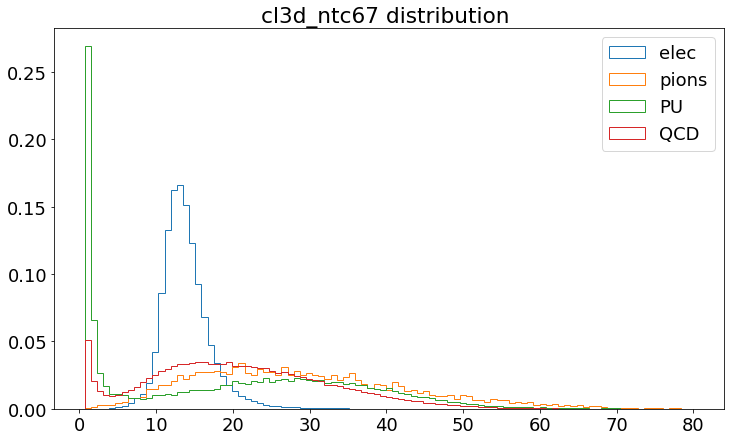

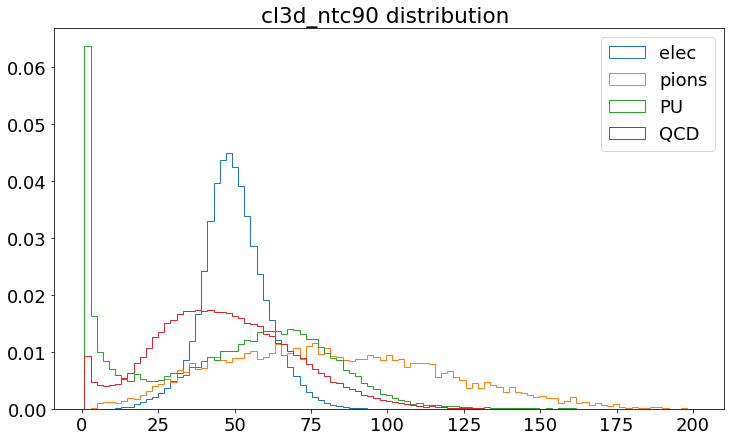

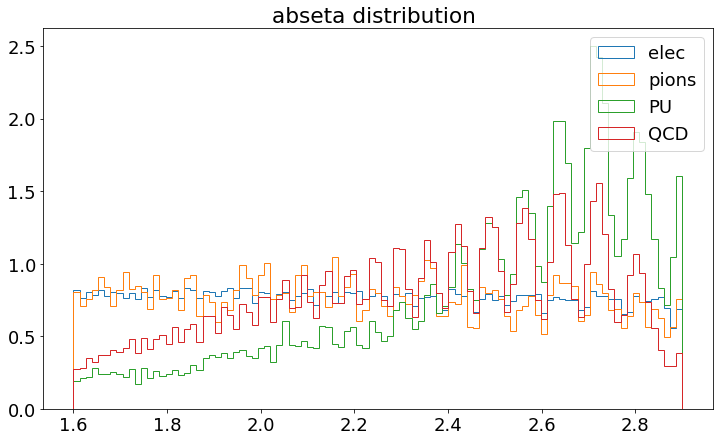

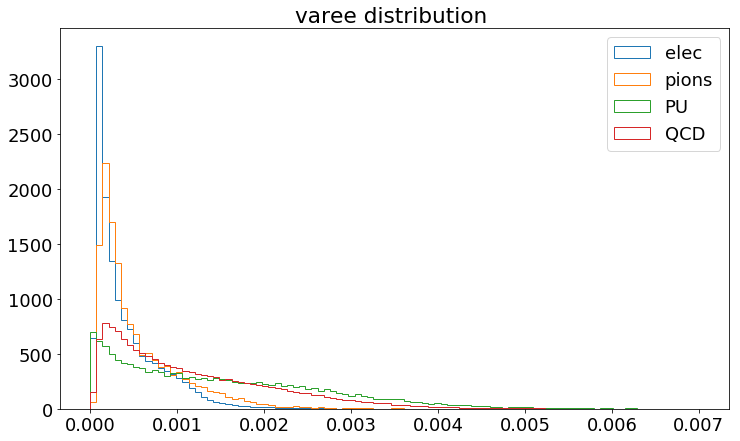

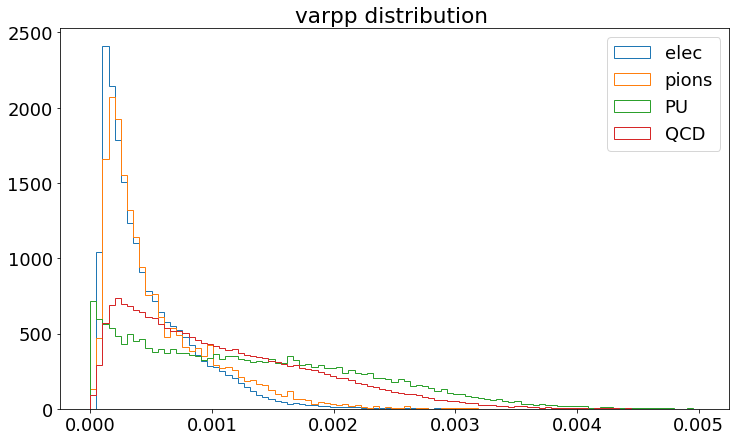

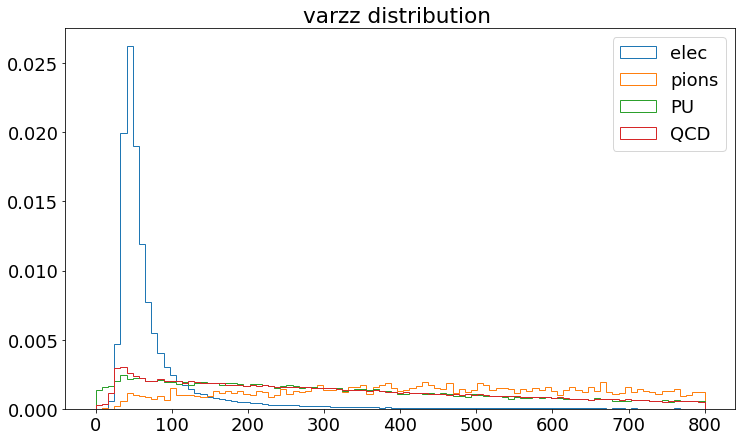

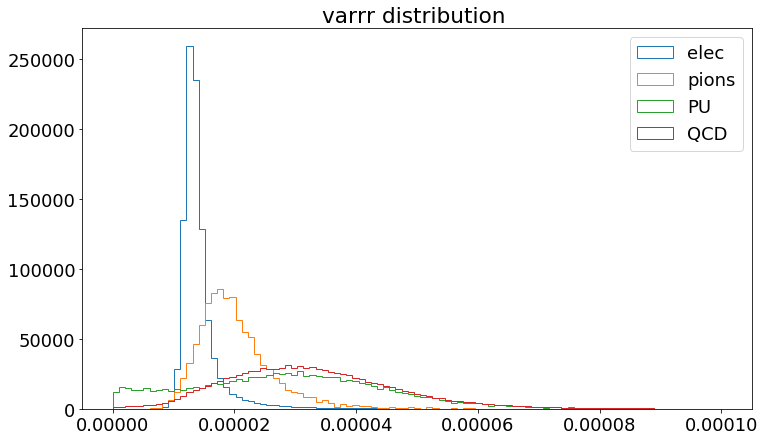

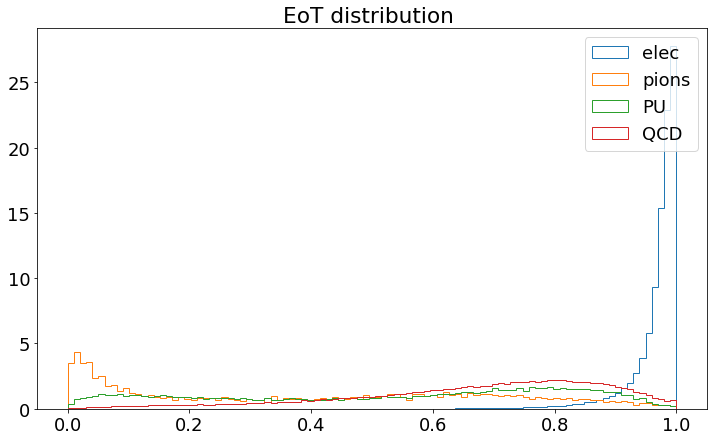

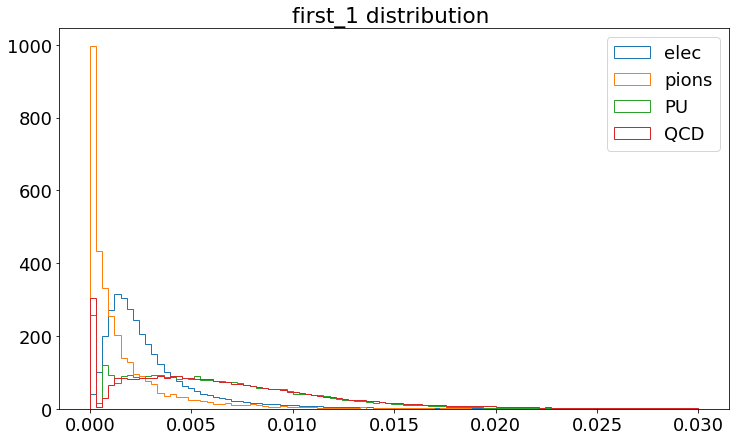

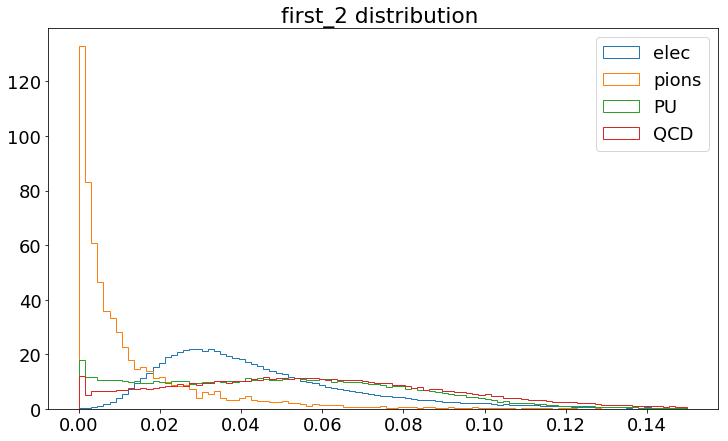

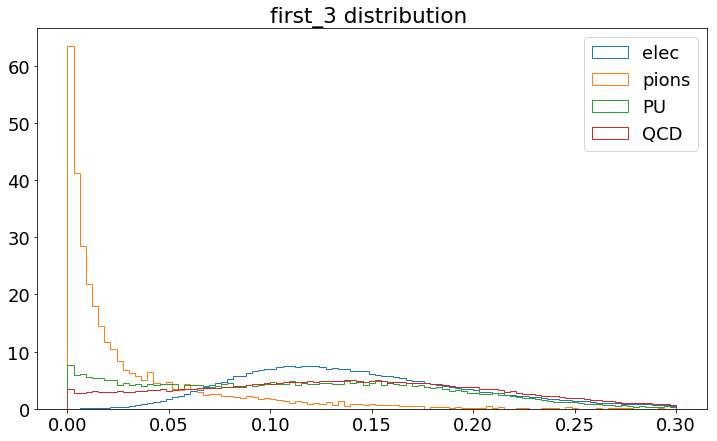

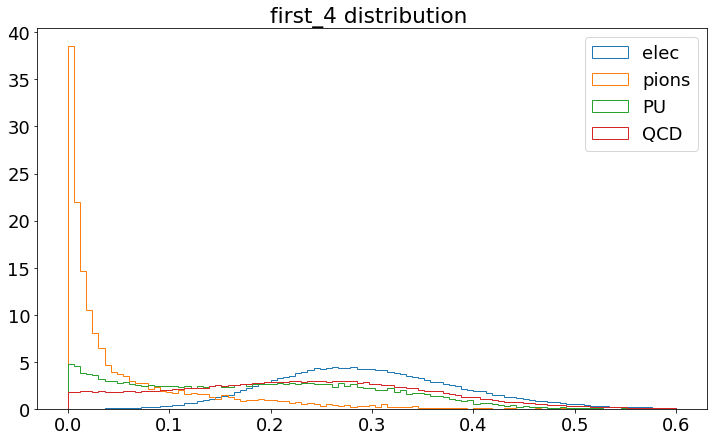

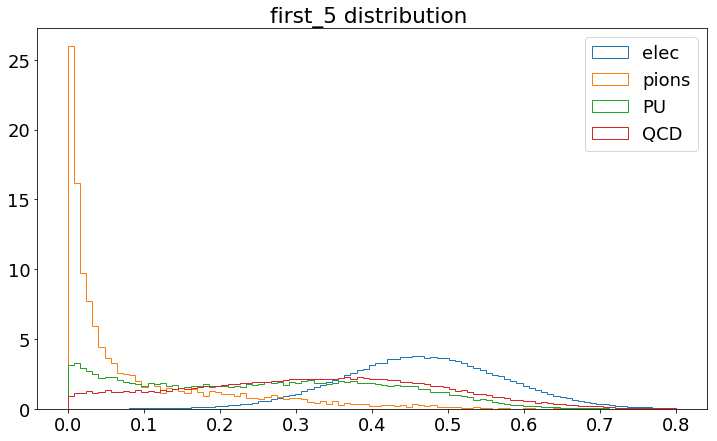

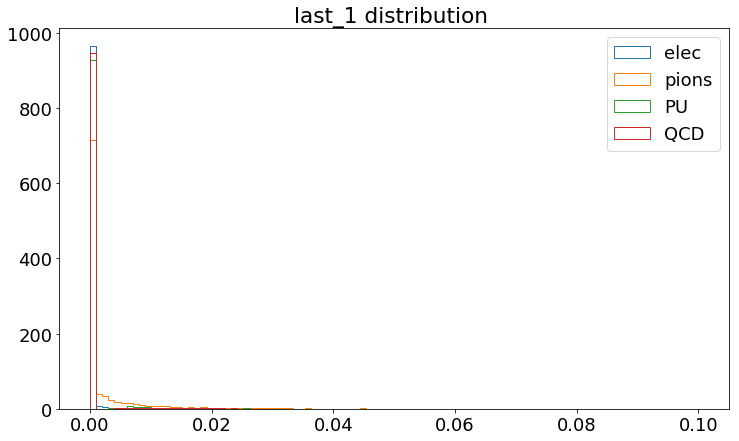

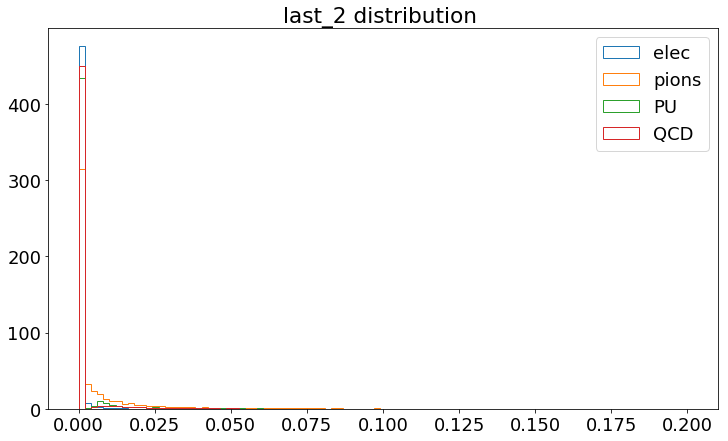

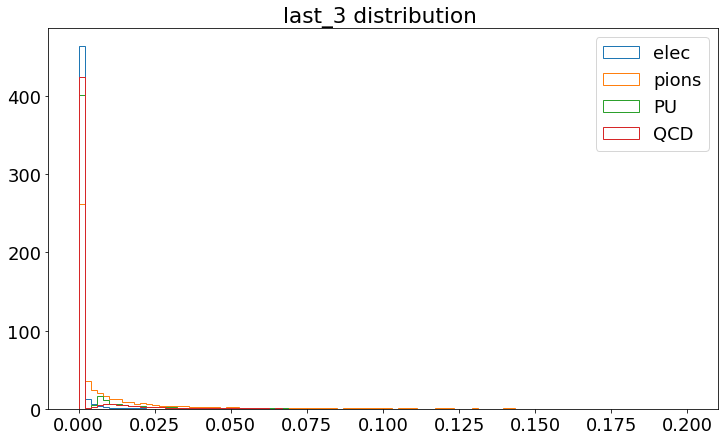

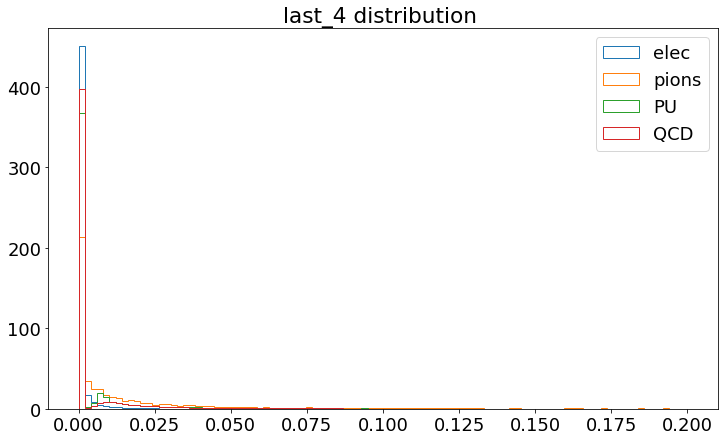

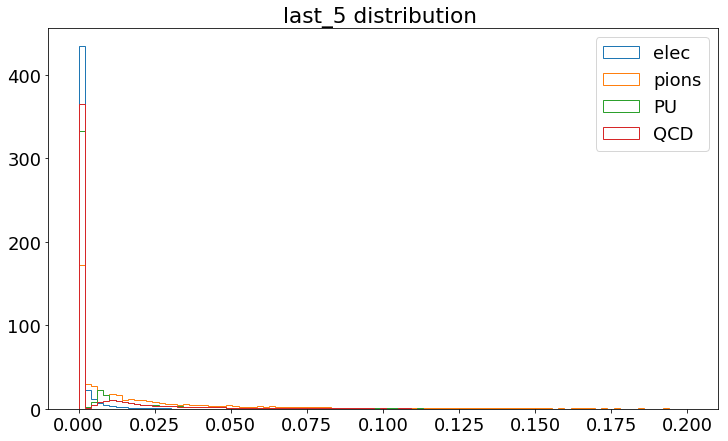

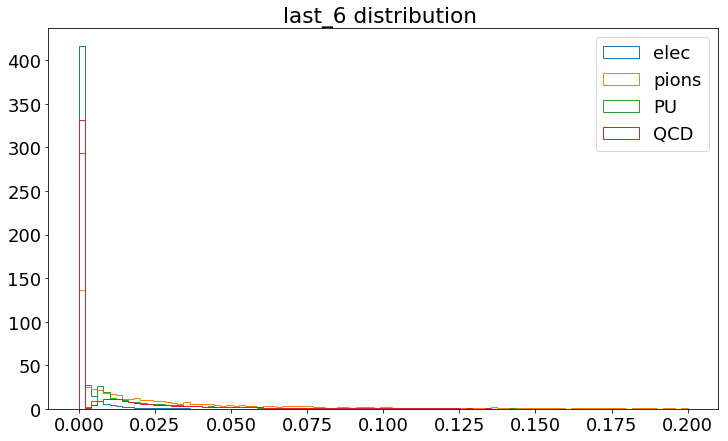

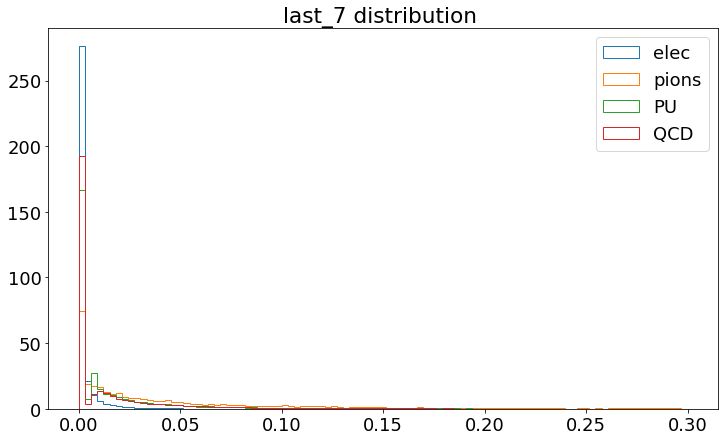

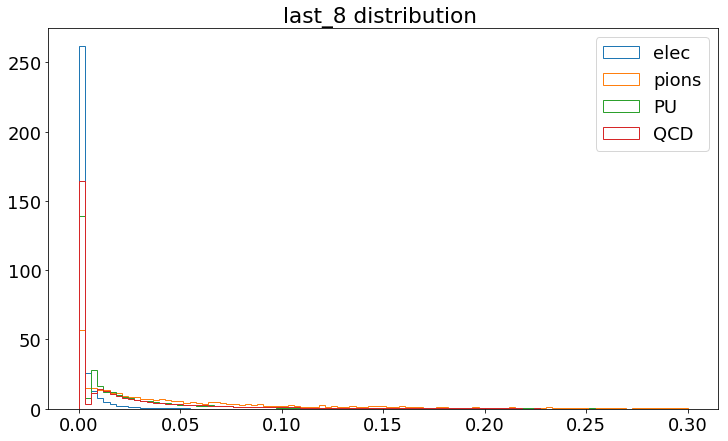

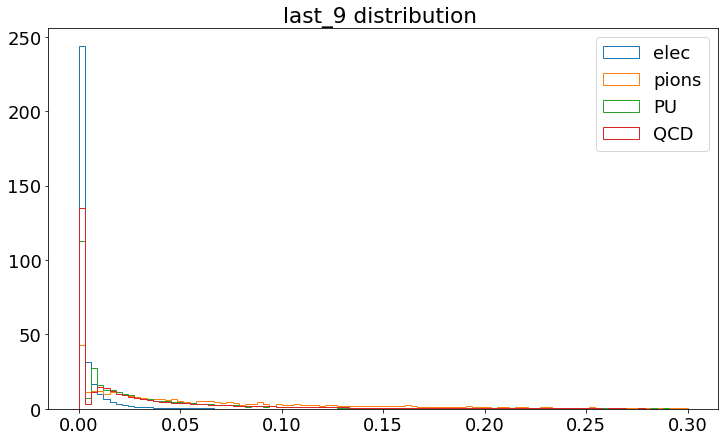

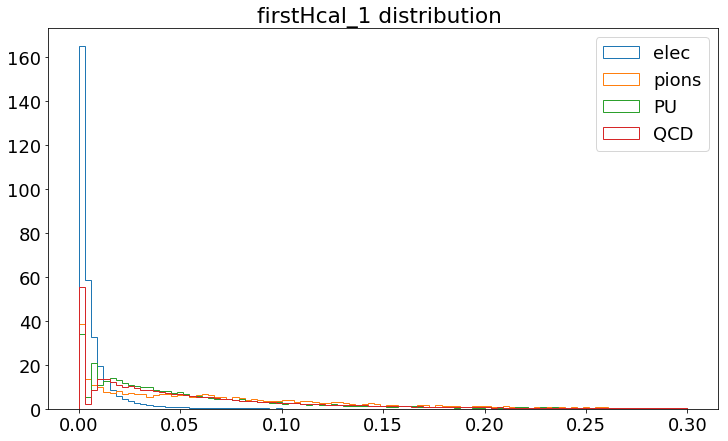

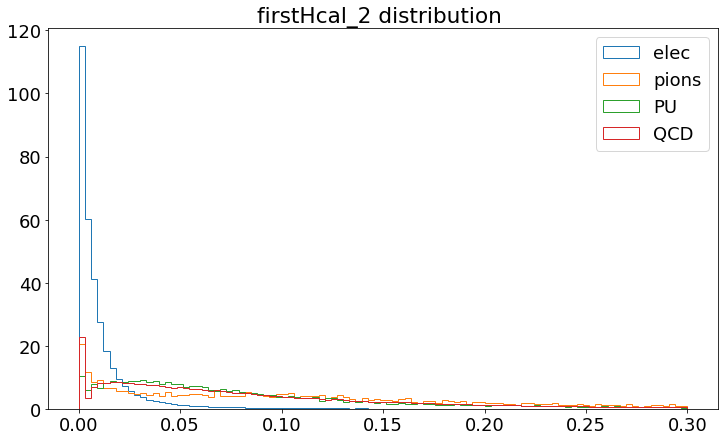

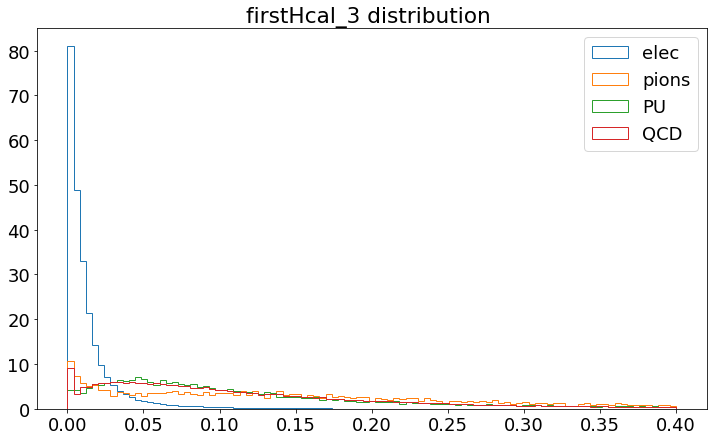

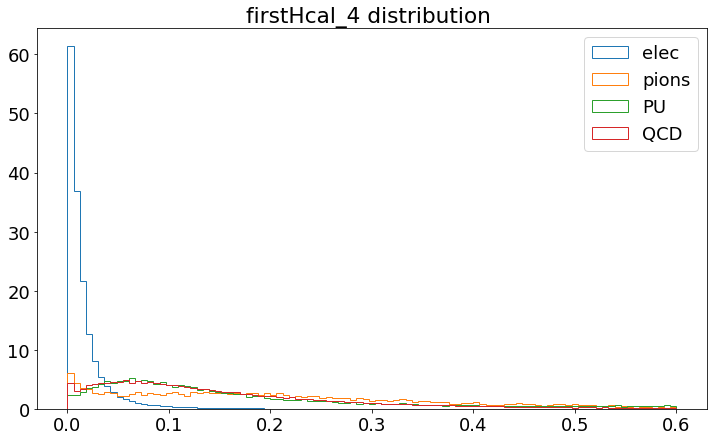

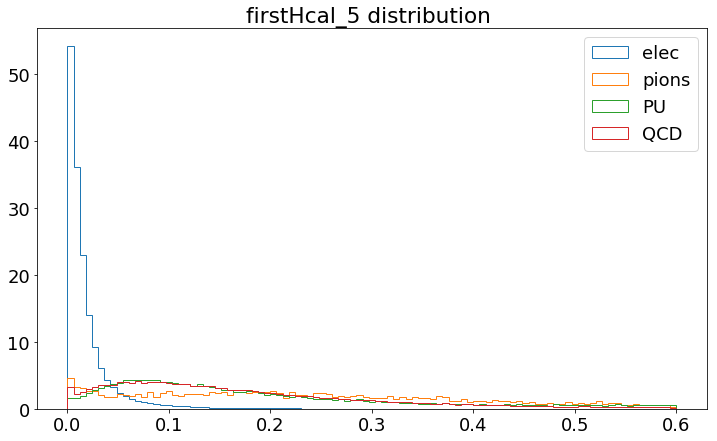

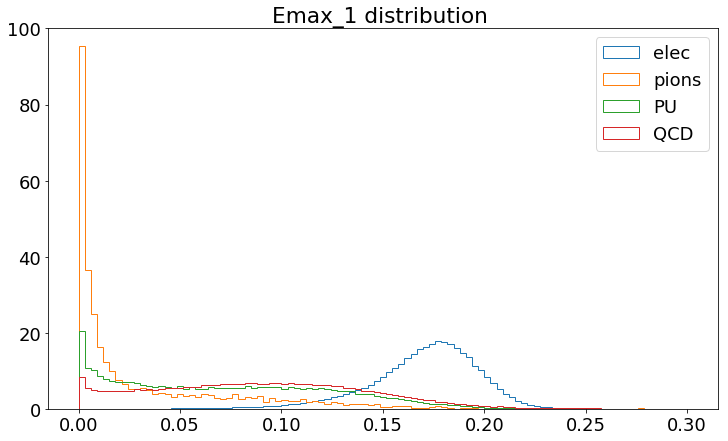

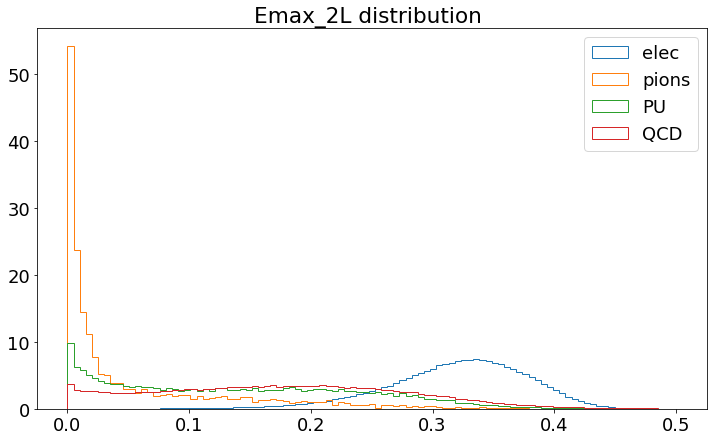

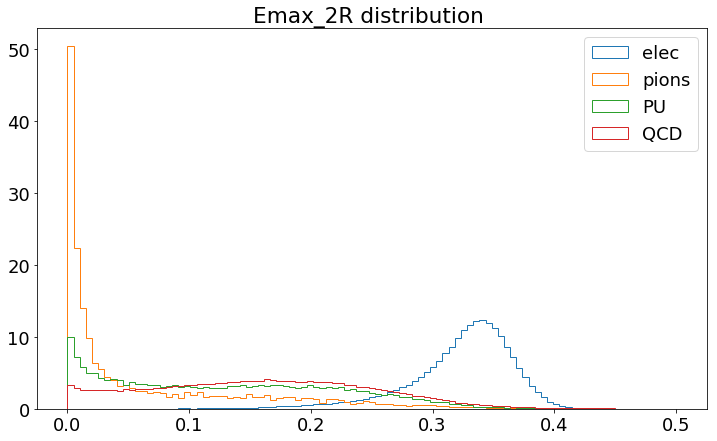

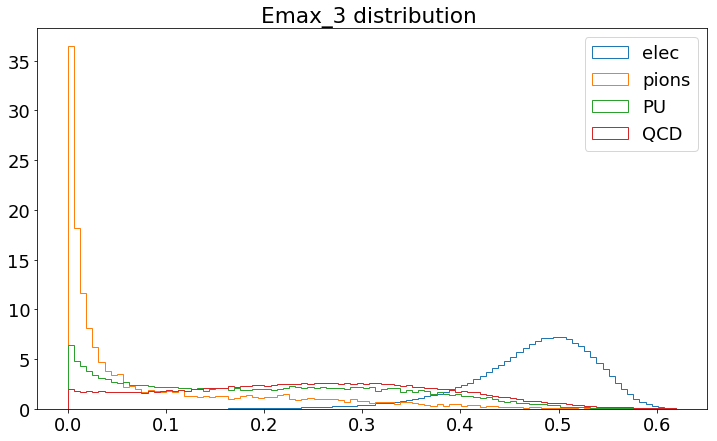

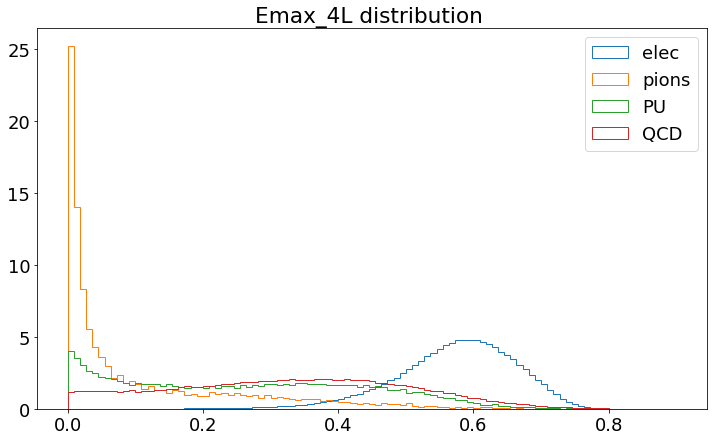

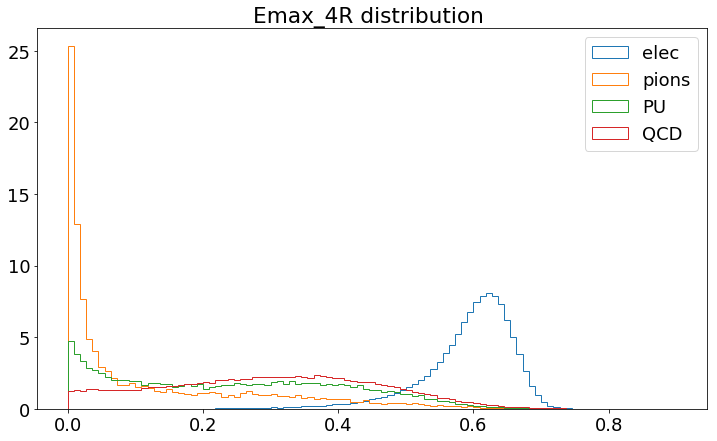

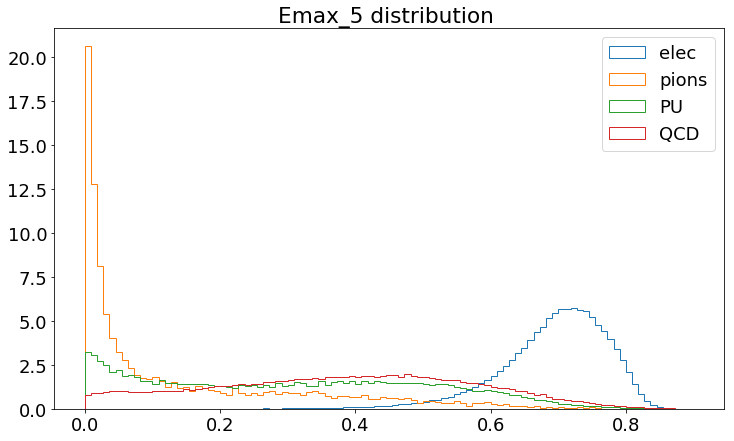

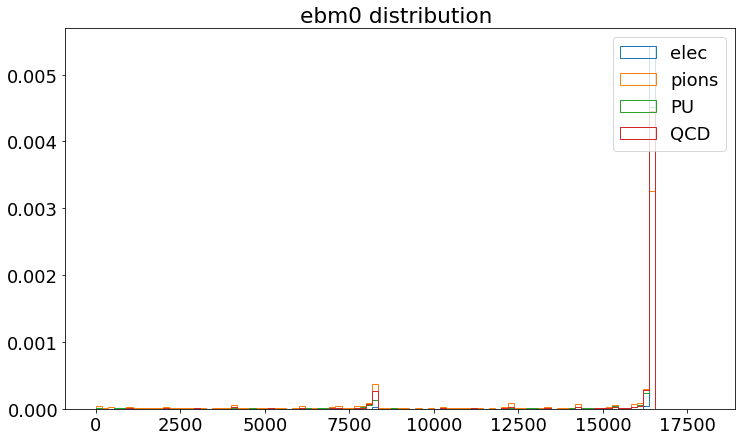

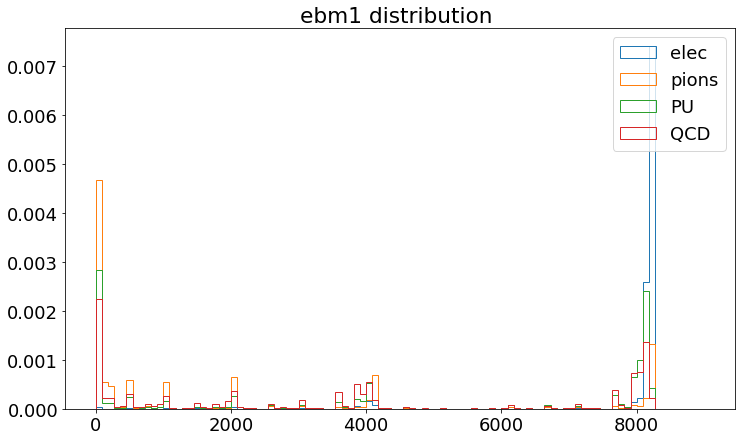

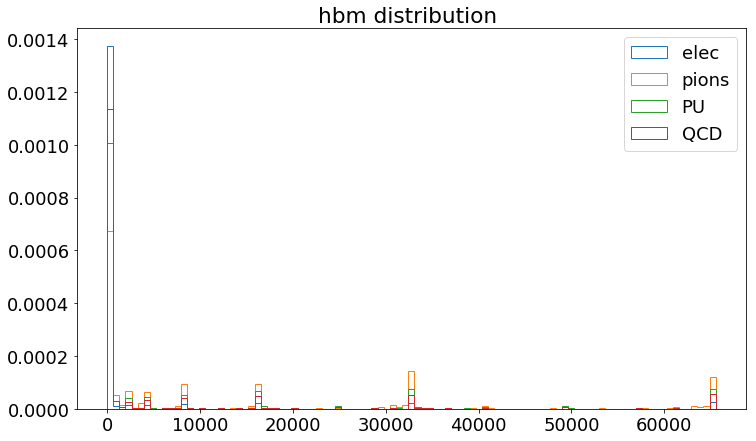

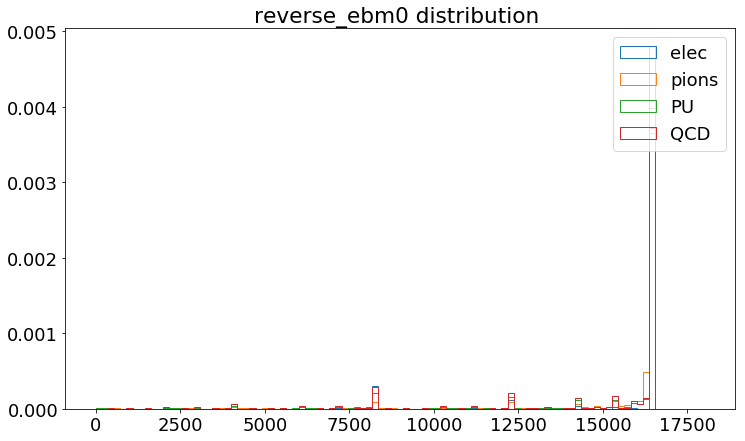

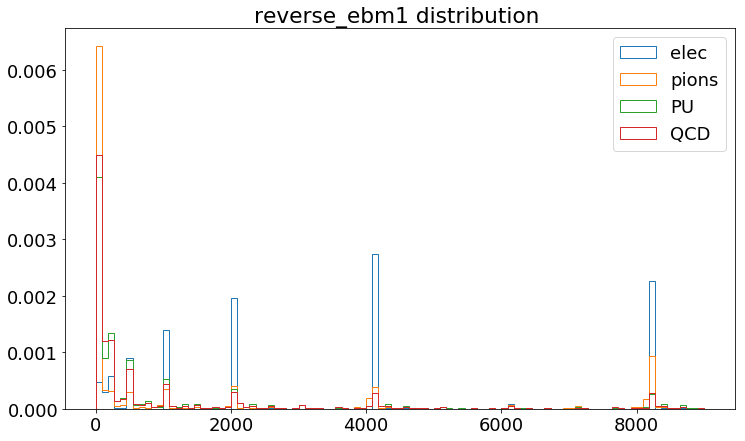

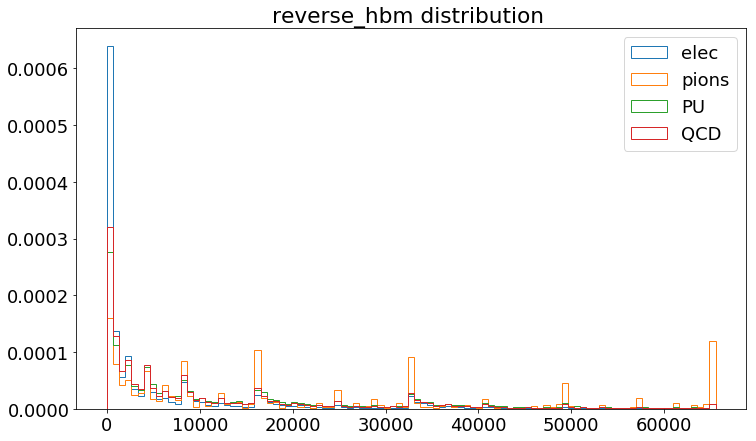

In [115]:
#plot features distrib
plot= True
if plot:
    var_list= ['cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer',
           'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_spptot',
           'cl3d_szz', 'cl3d_srrtot',
           'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
           'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 
           'abseta', 'varee', 'varpp', 'varzz', 'varrr', 'EoT', 'first_1', 'first_2',
            'first_3', 'first_4', 'first_5', 'last_1', 'last_2', 'last_3', 'last_4',
            'last_5', 'last_6', 'last_7', 'last_8', 'last_9', 'firstHcal_1', 'firstHcal_2',
            'firstHcal_3', 'firstHcal_4', 'firstHcal_5', 'Emax_1', 'Emax_2L', 'Emax_2R', 'Emax_3',
            'Emax_4L', 'Emax_4R', 'Emax_5', 'ebm0', 'ebm1', 'hbm', 'reverse_ebm0', 'reverse_ebm1', 'reverse_hbm']

    nbins=100
    binmin=[1, 1, 1, 1, 0, 0, 0.0, 0.0, 0., -1.0, 328.15726, 0., 1.5, 4.004325, 0.67, 0.9, 1.6, 0, 0, 0.0, 0.0,
     0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    binmax=[50.0, 36.0, 34.0, 50.0, 0.09, 0.075, 90, 0.01, 1, 5, 500, 36, 36, 36, 80, 200, 2.9, 0.007,
         0.005, 800, 0.0001, 1.0, 0.03, 0.15, 0.3, 0.6, 0.8,0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 
            0.3, 0.3,0.4, 0.6, 0.6,0.3,0.5,0.5,0.62,0.9,0.9,0.9,18000,9000,65536,18000,9000,65536]
    
    os.makedirs(workdir + '/distrib', exist_ok=True)
    for i,feat in enumerate(var_list):
        if i in [0,1,2,3]:
            nbins=36
        else: nbins= 100
        #print(feat, binmin[i], binmax[i])
        bins=np.linspace(binmin[i],binmax[i],nbins)
        plt.figure(figsize=(12,7))
        plt.hist(df_cut[feat][df_cut['sample']=='elec'], bins=bins, label='elec', density=True, histtype='step')
        plt.hist(df_cut[feat][df_cut['sample']=='pion'],bins=bins, label='pions', density=True, histtype='step')
        plt.hist(df_cut[feat][df_cut['sample']=='PU'],bins=bins, label='PU', density=True, histtype='step')
        plt.hist(df_cut[feat][df_cut['sample']=='QCD'],bins=bins, label='QCD', density=True, histtype='step')
        plt.title("{} distribution ".format(feat))
        #plt.yscale('log')
        #plt.xlim(0,36)
        plt.legend()

        plt.savefig(workdir+'/distrib/{}.png'.format(feat))

elec
pion
PU
QCD


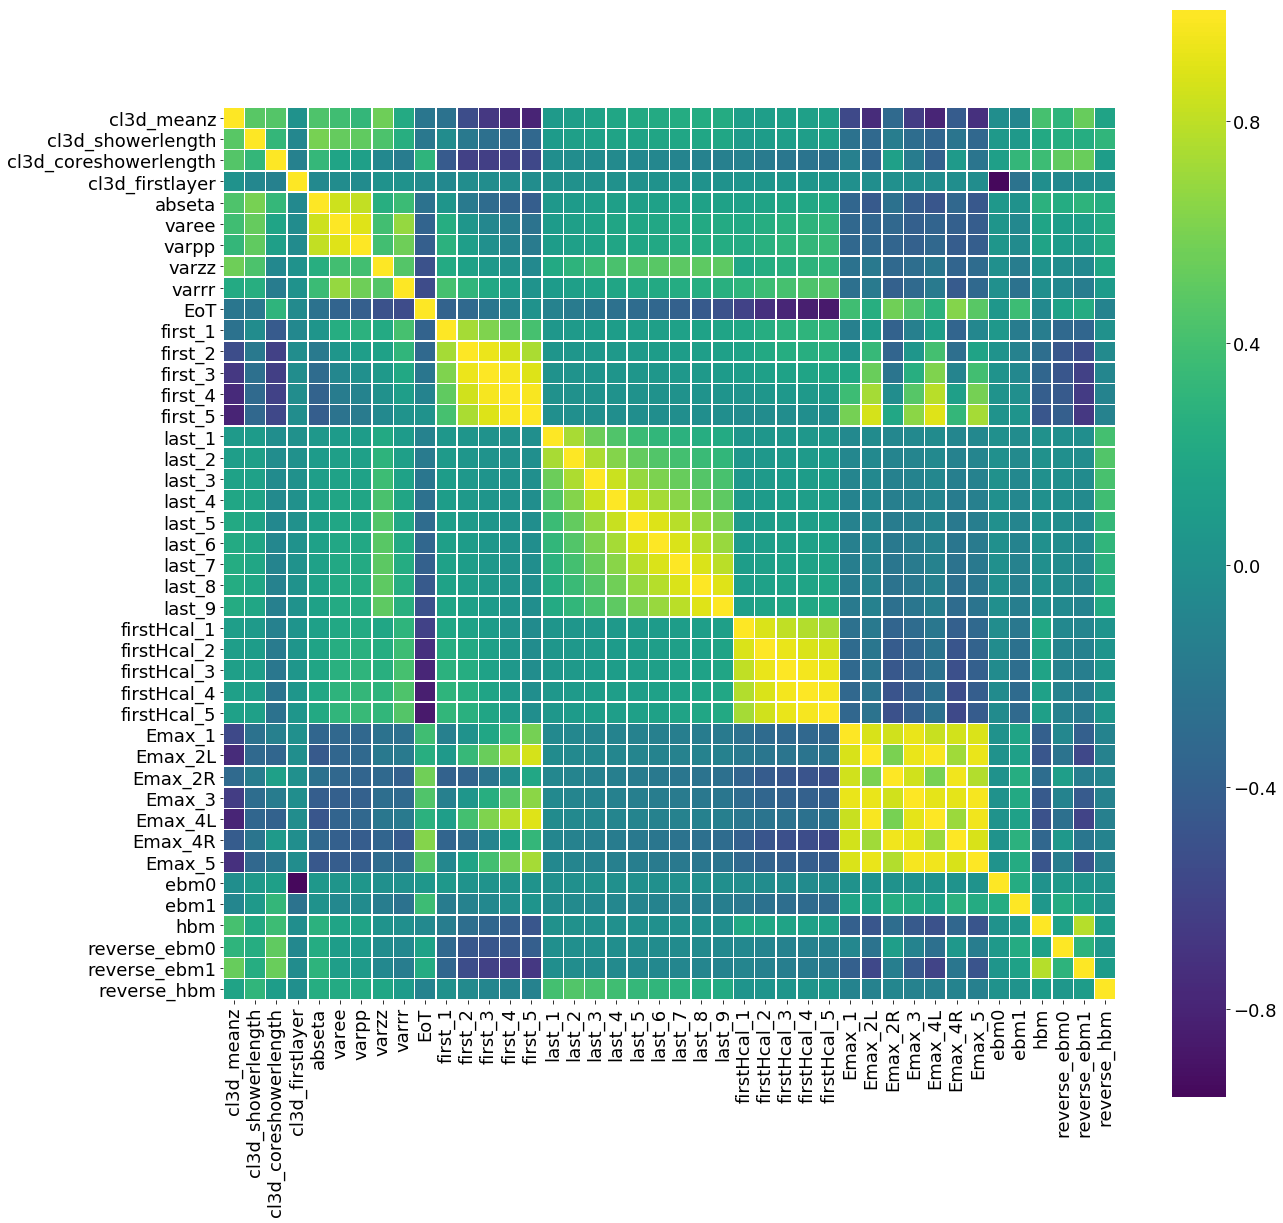

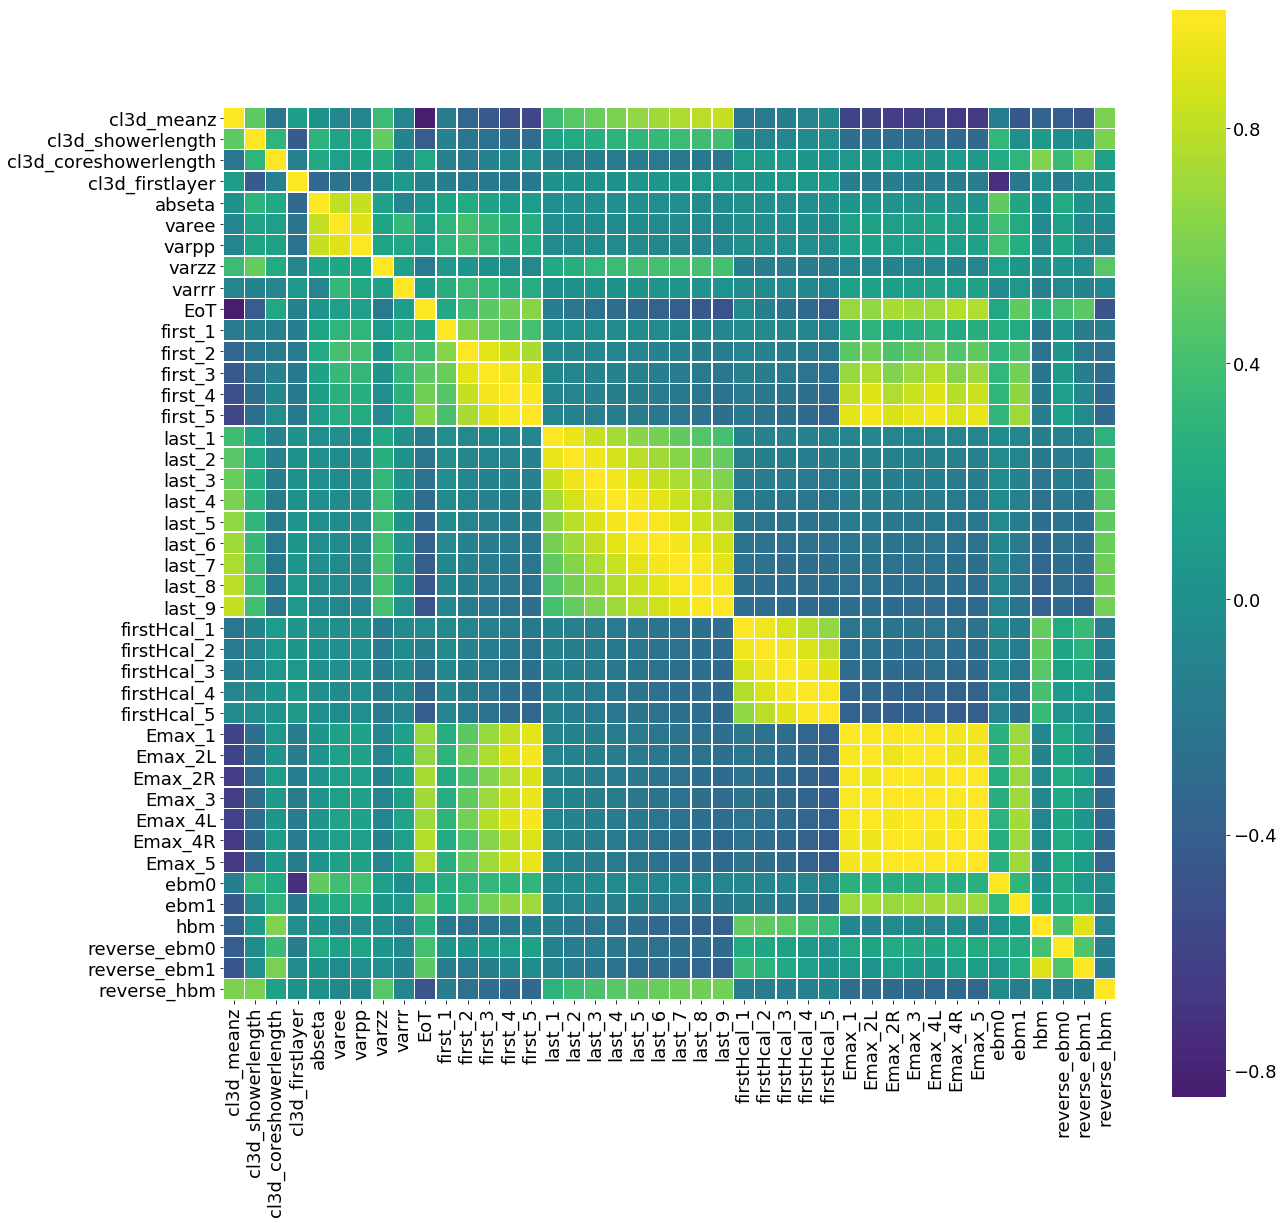

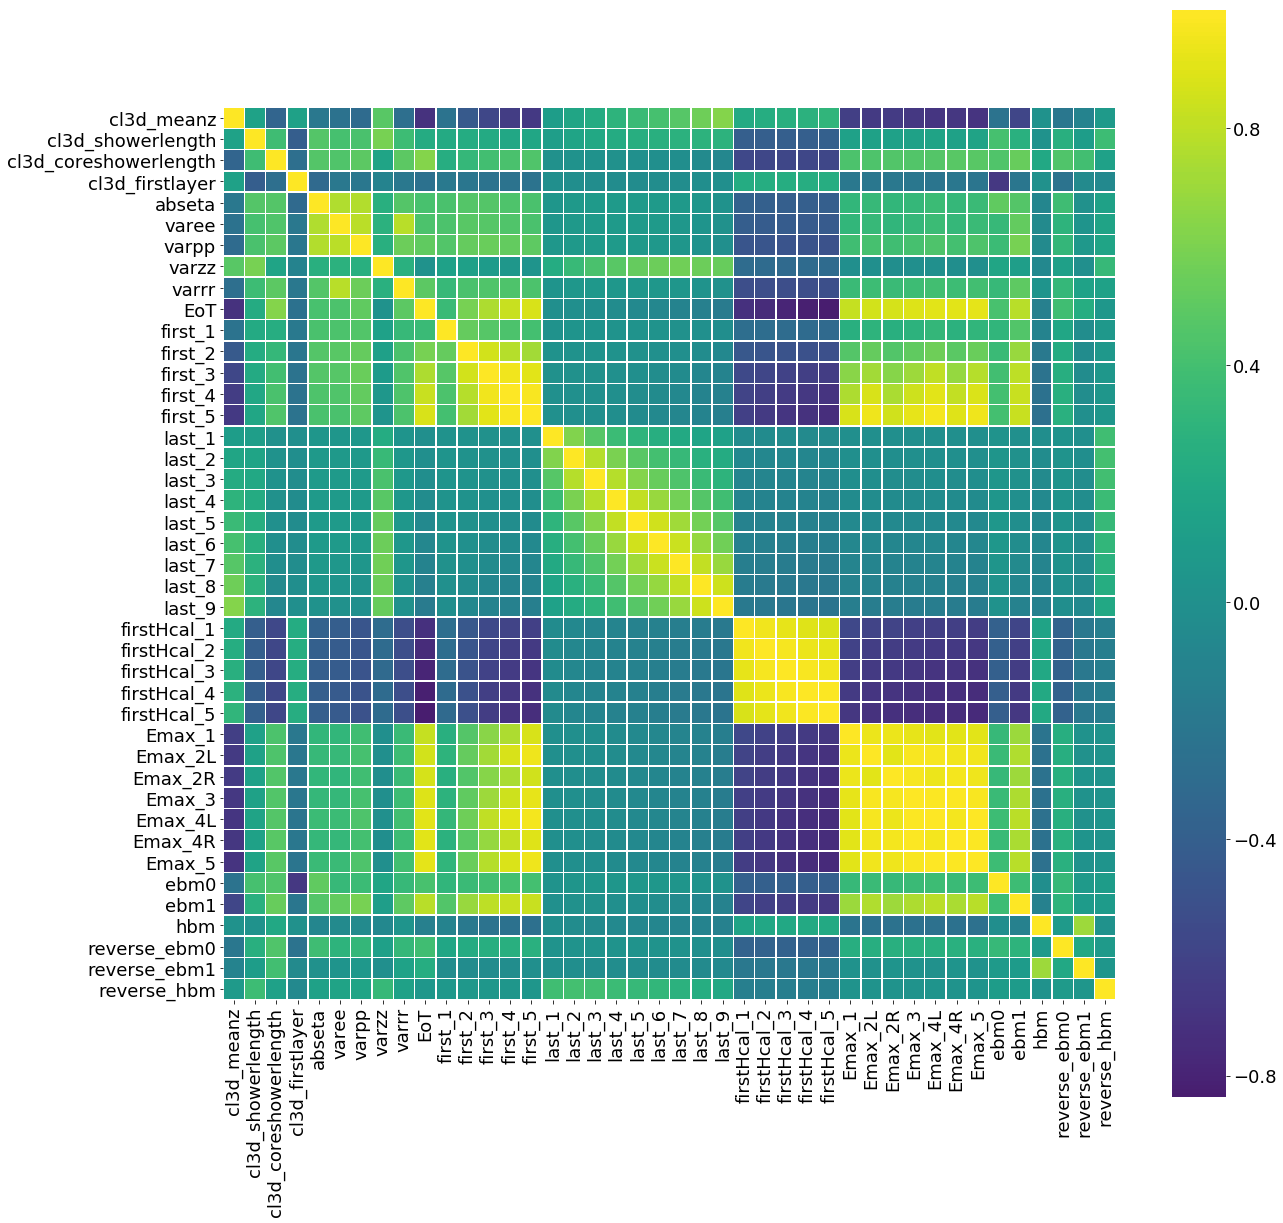

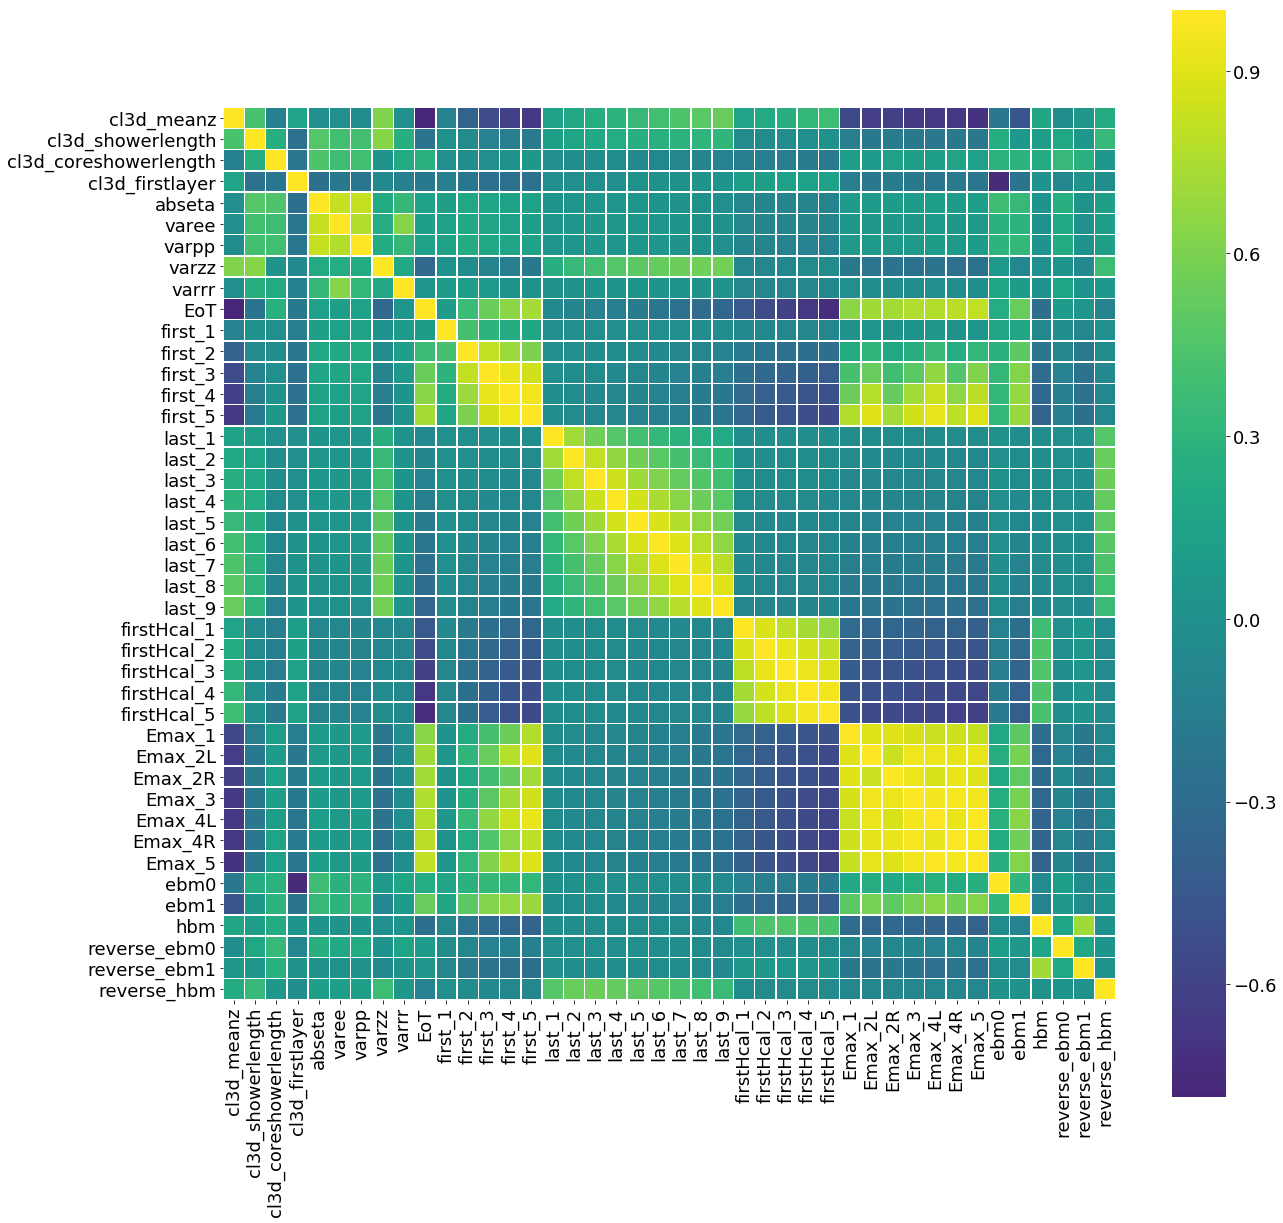

In [146]:
import seaborn as sns
corr={}
feat=['cl3d_meanz','cl3d_showerlength','cl3d_coreshowerlength','cl3d_firstlayer',
                'abseta', 'varee', 'varpp', 'varzz', 'varrr',
                  'EoT', 'first_1', 'first_2',
                'first_3', 'first_4', 'first_5', 'last_1', 'last_2', 'last_3', 'last_4',
                'last_5', 'last_6', 'last_7', 'last_8', 'last_9', 'firstHcal_1', 'firstHcal_2',
                'firstHcal_3', 'firstHcal_4', 'firstHcal_5', 'Emax_1', 'Emax_2L', 'Emax_2R', 'Emax_3',
                'Emax_4L', 'Emax_4R', 'Emax_5', 'ebm0', 'ebm1', 'hbm', 'reverse_ebm0', 'reverse_ebm1', 'reverse_hbm']
for i,sample in enumerate(['elec', 'pion', 'PU', 'QCD']):
    print(sample)
    corr[i]=df_cut[feat][df_cut['sample']==sample].corr()
    plt.figure(figsize=(20,20))
    sns_plot=sns.heatmap(corr[i], cmap='viridis', center=0,
                square=True, linewidths=.5, )
    fig = sns_plot.get_figure()
    fig.savefig(workdir+'/distrib/corr/{}_corr.png'.format(sample))


In [117]:
Counter(df_cut['sample'])

Counter({'elec': 225493, 'pion': 7276, 'PU': 29489, 'QCD': 135866})

In [126]:
x

In [133]:
import seaborn as sns

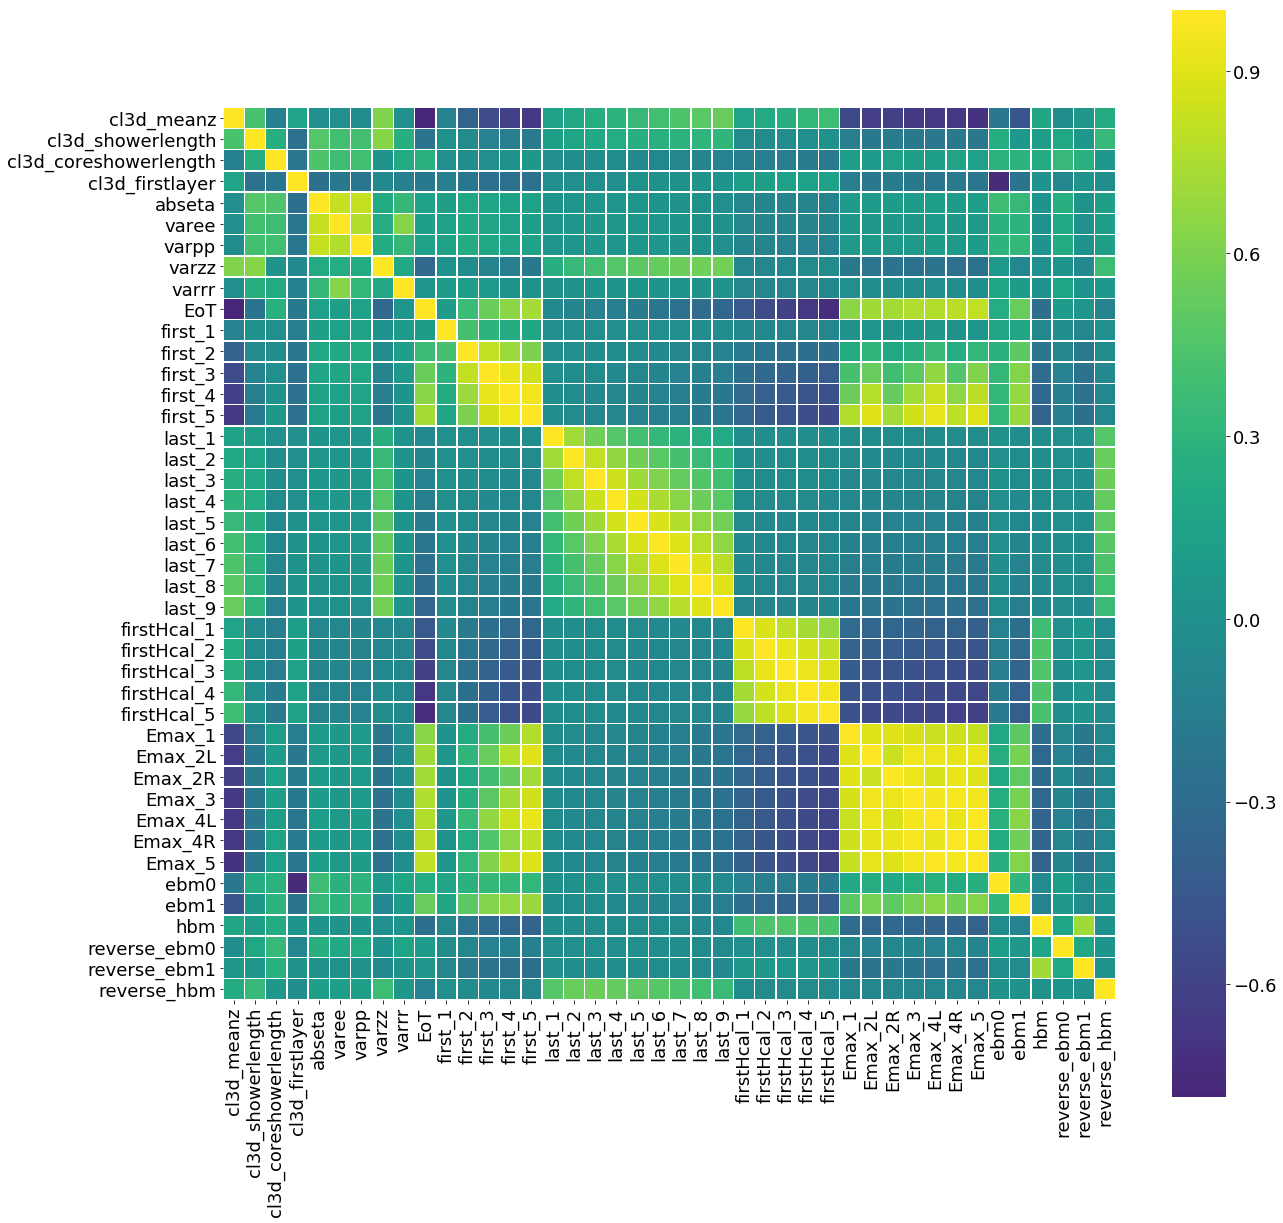

In [144]:
plt.figure(figsize=(20,20))
df_qcd=df_cut[feat][df_cut['sample']=='QCD']
sns.heatmap(df_qcd.corr(), cmap='viridis', center=0,
                square=True, linewidths=.5, )

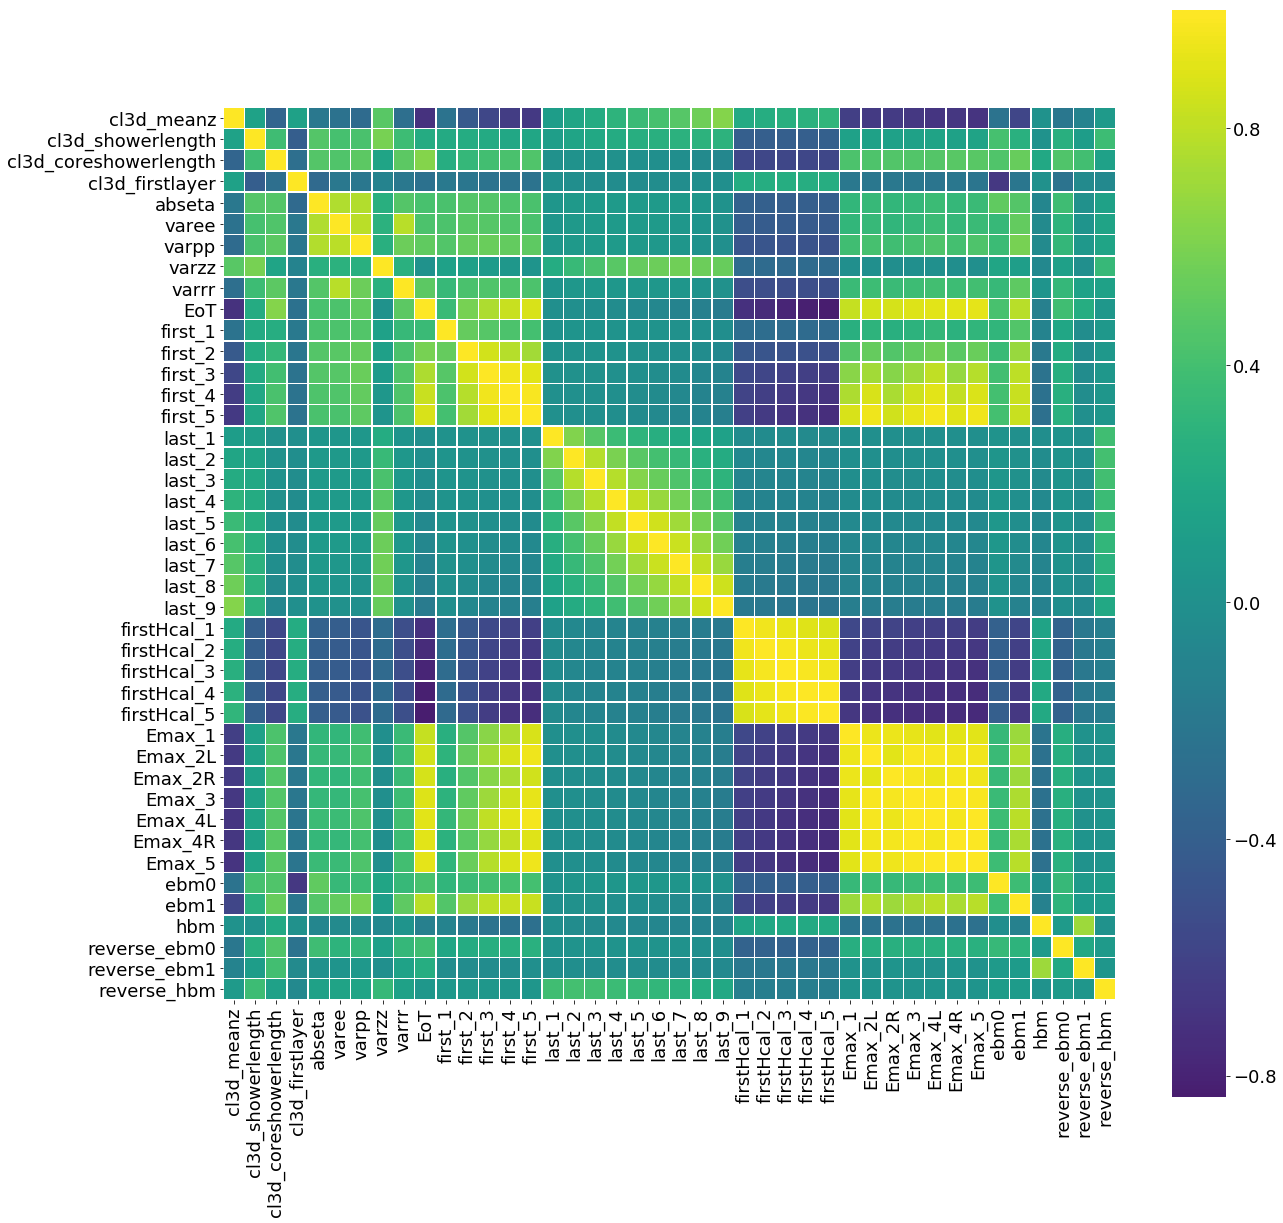

In [145]:
plt.figure(figsize=(20,20))
df_qcd=df_cut[feat][df_cut['sample']=='PU']
sns.heatmap(df_qcd.corr(), cmap='viridis', center=0,
                square=True, linewidths=.5, )